In [57]:
import requests
import pandas as pd
import numpy as np
import xarray as xr
import fsspec
import geopandas as gpd
from shapely.geometry import Point
import os
import dask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import mplcursors
from datetime import datetime, timedelta
import matplotlib as mpl

import netCDF4 as nc
from bs4 import BeautifulSoup
from p_tqdm import p_map
import seaborn as sns
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression


STATION_ID_DICT = {'1'  : 'WBAN',
                    '2'  : 'COOP',
                    '3'  : 'FAA',
                    '4'  : 'WMO',
                    '5'  : 'ICAO',
                    '6'  : 'GHCN',
                    '7'  : 'NWSLI OR SHEF',
                    '9'  : 'THRDX',
                    '10' : 'COCORAHS',
                    '11' : 'DEOS',
                    '12' : 'MOWX',
                    '13' : 'MIWX',
                    '17' : 'SCAN',
                    '19' : 'TSCAN',
                    '22' : 'OARDC',
                    '26' : 'NEWA',
                    '27' : 'CULOG',
                    '28' : 'NJWX',
                    '29' : 'CADX',
                    '30' : 'UCC',
                    '31' : 'NWON',
                    '32' : 'GHCNH',
                    '33' : 'CoAgMET'}

VAR_DICT = {1  : 'MaxT',
            2  : 'MinT',
            43 : 'AvgT',
            3  : 'Tobs',
            23 : 'Hourly T',
            4  : 'Daily Precip',
            5  : 'Hourly Precip',
            10 : 'Snowfall',
            11 : 'Snow Depth',
            13 : 'SWE'}


NETWORK_DICT = {'0' :'Unknown',
                '1' :'TD3200',
                '2' :'TD3210',
                '4' :'SHEF',
                '5' :'AWDN',
                '6' :'HCN',
                '7' :'CF6',
                '8' :'RCC keyed',
                '9' :'NRCC local',
                '13':'WRCC local',
                '14':'SRCC local',
                '15':'DSM',
                '16':'TD3206',
                '17':'GHCN-D',
                '19':'CF6',
                '22':'CADX',
                '25':'SCAN',
                '26':'TSCAN',
                '30':'CoAgMet',
                '52':'TD3205',
                '53':'TD3299',
                '54':'ThreadEx',
                '56':'CRB'}

GHCND_SOURCE_DICT = {'0' : 'COOP-0',
                     '6' : 'COOP-6',
                     '7' : 'COOP-7',
                     'A' : 'ASOS-A',
                     'B' : 'ASOS-B',
                     'K' : 'COOP-K',
                     'N' : 'CoCoRaHS',
                     'T' : 'SNOTEL'}



STATION_ID_PREF_ORDER = ['GHCN', 'COOP', 'WBAN', 'ICAO']


def get_preferred_sid(all_sids, sid_types):
    ''' Helper function to retreive the preferred Station ID from all returned by ACIS '''
    
    for stype in STATION_ID_PREF_ORDER:
        if stype in sid_types:
            sid = all_sids[sid_types.index(stype)]
            sid_type = stype
            break
        else:
            sid = all_sids[0]
            sid_type = sid_types[0]
    return sid, sid_type

def get_metadata(sids = None, bounds = None, metvar = 4):
    """
    Gets station metadata for within a bounding box or a list of station IDs

    Parameters
    ----------
    sids : list of strs
        list of station IDs to get metadata for.
    bbox : list of floats
        (W,S,E,N) bounds to get stations within
    metvar: integer
        ACIS variable number to get the spand of dates with available data for

    Returns
    -------
    station_metadata_df : pandas dataframe

    """
    
    if (sids == None) & (bounds == None):
        print('Must provide either a list of Station IDs, or a bounding box')
    
    url = 'https://data.nrcc.rcc-acis.org/StnMeta'
    
    
    if sids != None:
        params = {'sids':','.join(sids), 
                  'meta':"name,ll,sids,state,elev,sid_dates,valid_daterange,tzo",
                  "elems":str(metvar)
                  }
        params = [('params', str(params).replace("'",'"'))]
        response     = requests.post(url, data=params)
        result_df   = pd.DataFrame(response.json()['meta'])  
        
    if bounds != None:
        params = {'bbox': ','.join(map(str, bounds)),
                  'meta':"name,ll,sids,state,elev,sid_dates,valid_daterange,tzo",
                  "elems":str(metvar)
                  }
        params = [('params', str(params).replace("'",'"'))]
        response     = requests.post(url, data=params)
        result_df   = pd.DataFrame(response.json()['meta'])  
        
    
    station_metadata_df = pd.DataFrame()
    for i in result_df.index:
        result_df_i = result_df.loc[i]
        
        #pull out Station IDs and Station ID Types (i.e. GHCN)
        sids_info = result_df_i['sids']
        all_sids, sid_types = zip(*[sid.split(' ') for sid in sids_info])
        sid_types = [STATION_ID_DICT[k] for k in sid_types]
        
        #get the preferred Station ID
        sid, sid_type = get_preferred_sid(all_sids, sid_types)
                
        #fill in the rest of the Station IDs if we have them
        for stype in STATION_ID_PREF_ORDER:
            if stype in sid_types:
                station_metadata_df.loc[sid, f'{stype} ID'] = all_sids[sid_types.index(stype)]
                
        #pull out valid date range for each sid
        for stype in STATION_ID_PREF_ORDER:
            if stype in sid_types:
                start_date, end_date = result_df_i['sid_dates'][sid_types.index(stype)][1:]
                if '9999' in end_date: end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
                start_date = pd.to_datetime(start_date, errors = 'coerce')
                end_date = pd.to_datetime(end_date)
                station_metadata_df.loc[sid, f'{stype} Start Date'] = start_date
                station_metadata_df.loc[sid, f'{stype} End Date'] = end_date
        
        #get recording date range for requested variable
        start_date, end_date = result_df_i['valid_daterange'][0]
        if '9999' in end_date: end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
        start_date = pd.to_datetime(start_date, errors = 'coerce')
        end_date = pd.to_datetime(end_date)
        station_metadata_df.loc[sid, 'Start Date'] = start_date
        station_metadata_df.loc[sid, 'End Date'] = end_date
        
        #get other station metadata
        station_metadata_df.loc[sid, 'Station ID Type'] = sid_type
        station_metadata_df.loc[sid, 'Name'] = result_df_i['name']
        station_metadata_df.loc[sid, ['Longitude', 'Latitude']] = result_df_i['ll']
        station_metadata_df.loc[sid, 'Elevation'] = result_df_i['elev']
        station_metadata_df.loc[sid, 'UTC Offset'] = result_df_i['tzo']
        
    if len(station_metadata_df) == 0:
        station_metadata_df = pd.DataFrame(columns = ['GHCN ID', 'COOP ID', 'WBAN ID', 'ICAO ID', 'GHCN Start Date',
                                                      'GHCN End Date', 'COOP Start Date', 'COOP End Date', 'WBAN Start Date',
                                                      'WBAN End Date', 'ICAO Start Date', 'ICAO End Date', 'Start Date',
                                                      'End Date', 'Station ID Type', 'Name', 'Longitude', 'Latitude',
                                                      'Elevation', 'UTC Offset'])
        
    #convert timezone offset to datetime
    station_metadata_df['UTC Offset'] = pd.to_timedelta(station_metadata_df['UTC Offset'], unit = 'h')
    
    station_metadata_df = station_metadata_df.sort_index()
    station_metadata_df.index.name = 'Station ID'
        
    return station_metadata_df

def get_data(start_date, end_date, sids=None, bounds=None, metvar=None):
    '''
    Pulls station data from the ACIS API
    
    Must specify ONE of "sids" or "bounds"

    Parameters
    ----------
    start_date/end_date : datetime or date string
        start and end of period to grab data over
    sids : list of strings, optional
        A list of station IDs to grab data for
    bounds : tuple of floats
        Geographic range to search for stations over. (min_lon, min_lat, max_lon, max_lat)
    metvar : int, optional
        Meteorological variable to grab data for.
        I can't find good documentation of a full list of possible varibles,
        but you can find the most common ones in the dictrioary "VAR_DICT" at the top of this code
        The default is 4 (Daily Precipitation)

    Returns
    -------
    station_metadata_df : pandas dataframe
        A DataFrame with station metadata (latitude, kongitude, etc.)
    station_df : pandas dataframe
        A DataFrame with station data and flags.

    '''
    
    url = 'https://data.nrcc.rcc-acis.org/MultiStnData'
    
    if metvar in [5,23]:
        freq = 'hourly'
    else:
        freq = 'daily'
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    #account for time zones by adding two days on either side
    start_date_buff = (start_date - pd.Timedelta(days = 2)).date()
    end_date_buff   = (end_date   + pd.Timedelta(days = 2)).date()
        
    params = {'sdate': start_date_buff.strftime('%Y%m%d'),
              'edate': end_date_buff.strftime('%Y%m%d'),
              'elems': [{'vX':metvar}],
              'meta':'sids'}        
    
    if sids != None:
        params['sids'] = ','.join(sids)
    
    if bounds != None:
        params['bbox'] = ','.join(map(str, bounds))

    #full meta information is only available for daily data
    if freq == 'daily':
        params['elems'][0]['add'] = 'f,n,t,s'

    params = [('params', str(params).replace("'",'"'))]
    response     = requests.post(url, data=params)
    result_df   = pd.DataFrame(response.json()['data'])
    
    if freq == 'daily': 
        rec_times = pd.date_range(start_date_buff, end_date_buff, freq = '1D')
    else:
        rec_times = pd.date_range(start_date_buff, end_date_buff+pd.Timedelta(days = 1), freq = '1h')[:-1]
        
    #extract data
    station_df = []
    for i in result_df.index:
        result_df_i = result_df.loc[i]['data']
        
        #pull out Station IDs and Station ID Types (i.e. GHCN)
        sids_info = result_df.loc[i]['meta']['sids']
        all_sids, sid_types = zip(*[sid.split(' ') for sid in sids_info])
        sid_types = [STATION_ID_DICT[k] for k in sid_types]
        
        #get the preferred Station ID
        sid, _ = get_preferred_sid(all_sids, sid_types)
        
        if freq == 'daily': 
            data, flags, networks, rec_hour, GHCN_sources = np.array(result_df_i).squeeze().T
            
            #process and adjust
            data = [float(d) if d != 'M' else np.nan for d in data]
            flags = [np.nan if f == ' ' else f for f in flags]
            networks = [NETWORK_DICT[n] for n in networks]
            rec_hour = rec_hour.astype(float)
            #replace unknown obs times with the most common value
            if len(rec_hour[rec_hour != -1]) > 0:
                rec_hour[rec_hour == -1] = np.bincount(rec_hour[rec_hour != -1.].astype(int)).argmax()
            else:
                rec_hour = rec_hour*0
            GHCN_sources = [np.nan if gs == ' ' else gs for gs in GHCN_sources]
    
            for ind,gs in enumerate(GHCN_sources):
                if gs in GHCND_SOURCE_DICT:
                    networks[ind] = f'{networks[ind]}/{GHCND_SOURCE_DICT[gs]}'
                else:
                    networks[ind] = f'{networks[ind]}'
            
            sid_df = pd.DataFrame(data = {'Date':rec_times,
                                          VAR_DICT[metvar]:data,
                                          'Flag':flags,
                                          'Source':networks})
            
            #add recording hour on
            sid_df['Date'] = sid_df['Date'] + pd.to_timedelta(rec_hour, unit = 'h')
            
        if freq == 'hourly': 
            data = np.array(result_df_i).squeeze().ravel()
            data = [float(d) if d != 'M' else np.nan for d in data]
            
            sid_df = pd.DataFrame(data = {'Date':rec_times,
                                          VAR_DICT[metvar]:data})
            
            #add one hour so it represents end of recording hour
            sid_df['Date'] = sid_df['Date'] + pd.Timedelta(hours = 1)
            
        #add Station ID
        sid_df['Station ID'] = sid
                    
        station_df.append(sid_df)
    
    #if no data was found, just make an empty dataframe
    if len(station_df) == 0:
        station_df = [pd.DataFrame(columns = ['Date', VAR_DICT[metvar], 'Station ID'])]
        
    station_df = pd.concat(station_df)
            
    #get station metadata
    if bounds != None:
        station_metadata_df = get_metadata(bounds = bounds, metvar = metvar)
    else:
        station_metadata_df = get_metadata(sids = sids, metvar = metvar)
    
    #remove station metadata for station we didn't find any data for
    station_metadata_df = station_metadata_df[station_metadata_df.index.isin(station_df['Station ID'])]
    
    #check that all stations we just got data for also have metadata for
    assert(station_df['Station ID'].isin(station_metadata_df.index).all())
    
    #convert to UTC
    for sid in station_metadata_df.index:
        station_df.loc[station_df['Station ID'] == sid, 'Date'] -= station_metadata_df.loc[sid, 'UTC Offset']
    
    #set and sort index
    station_df = station_df.set_index(['Station ID', 'Date']).sort_index()
    
    #trim to just desired dates
    if freq == 'daily':
        station_df = station_df.xs(slice(start_date+pd.Timedelta(hours = 1),
                                         end_date+pd.Timedelta(hours = 23)), 
                                   level = 'Date', drop_level = False)
    else:
        station_df = station_df.xs(slice(start_date+pd.Timedelta(hours = 1), 
                                         end_date), 
                                   level = 'Date', drop_level = False)
        
    #convert to mm if needed
    if 'precip' in VAR_DICT[metvar].lower():
        station_df[VAR_DICT[metvar]] *= 25.4
    
    return station_metadata_df, station_df

In [58]:
########################### Input dates and bounds and run function to get station ##########################
# Load the shapefile
shapefile_path = r'C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\watershed_shapefiles\TVA_Watershed.shp'
gdf = gpd.read_file(shapefile_path)
bounds = gdf.total_bounds # Can either use the bounds determined by a shapefile or manually input them below
bounds = [bounds[0], bounds[1], bounds[2], bounds[3]]
print(bounds)

[-88.54351835864634, 34.11431614928304, -81.26342801118204, 37.24047651796086]


In [59]:
year = 2004
start_month = '01' # must be str
end_month = '12' # must be str
start_day = '01' # must be str
end_day = '31' # must be str

start_date='{year}-{start_month}-{start_day}T00:00:00'.format(year=year, start_month=start_month,start_day=start_day)
end_date='{year}-{end_month}-{end_day}T23:00:00'.format(year=2022, end_month=end_month,end_day=end_day)

In [60]:
# Run function to get station data
station_metadata_df, station_df = get_data(start_date=start_date, end_date=end_date, bounds=bounds, metvar=5)

In [61]:
######################## Function to get stations only within shapefile area ###########################
gdf_weather = gpd.GeoDataFrame(
    station_metadata_df, 
    geometry=gpd.points_from_xy(station_metadata_df['Longitude'], station_metadata_df['Latitude']),
    crs=gdf.crs
)

# Perform spatial join to filter stations within the shapefile's geometry
gdf_filtered = gpd.sjoin(gdf_weather, gdf, how='inner')

# Drop the join index and keep only the original weather station columns
gdf_filtered = gdf_filtered.drop(columns=['index_right'])

df_filtered = pd.DataFrame(gdf_filtered.drop(columns='geometry'))
df_filtered = df_filtered.dropna(subset=['GHCN ID']) # Grabs only GHCN stations as these have longest periods of record generally

In [62]:
tva_stations = df_filtered.drop(columns=['COOP ID', 'WBAN ID', 'ICAO ID', 'GHCN Start Date',
       'GHCN End Date', 'COOP Start Date', 'COOP End Date', 'WBAN Start Date',
       'WBAN End Date', 'ICAO Start Date', 'ICAO End Date',
       'End Date', 'Station ID Type', 'Name', 'UTC Offset', 'region_num']) 
tva_stations = tva_stations.drop(['USW00013806'])
tva_stations2 = tva_stations.reset_index()
print(tva_stations2)

    Station ID      GHCN ID Start Date  Longitude  Latitude  Elevation
0  USW00003812  USW00003812 1996-07-01  -82.53787  35.43178     2118.0
1  USW00003847  USW00003847 1996-07-01  -85.08141  35.95097     1865.0
2  USW00003856  USW00003856 1996-07-01  -86.78615  34.64406      623.0
3  USW00003894  USW00003894 2001-04-10  -87.41174  36.61689      550.0
4  USW00013877  USW00013877 1996-07-01  -82.39893  36.47964     1496.0
5  USW00013882  USW00013882 1996-07-01  -85.20039  35.03363      669.0
6  USW00013891  USW00013891 1996-07-01  -83.98573  35.81801      971.0
7  USW00013896  USW00013896 1996-07-01  -87.59971  34.74388      544.0
8  USW00053852  USW00053852 1996-10-23  -86.94343  34.65798      588.0
9  USW00053868  USW00053868 1998-09-01  -84.23370  36.02300      900.0


In [63]:
# Merge dataframes
merger = pd.merge(station_df, tva_stations, left_on='Station ID', right_index=True)
merged_df = merger.reset_index()

# comment out these two lines if you are looking for the top precip events 
merged_df = merged_df.dropna() # drops rows with NaN
merged_df = merged_df.loc[merged_df['Hourly Precip'] != 0] # drops rows where precip is zero

print(merged_df.iloc[7229])

###################### Now we have the desired stations for the day and area ##########################

Station ID               USW00003812
Date             2015-06-22 21:00:00
Hourly Precip                  45.72
GHCN ID                  USW00003812
Start Date       1996-07-01 00:00:00
Longitude                  -82.53787
Latitude                    35.43178
Elevation                     2118.0
Name: 100580, dtype: object


In [64]:
# Define a function to map each month to its corresponding season
def get_season(month):
  if month in [12, 1, 2]:
      return 'Winter'
  elif month in [3, 4, 5]:
      return 'Spring'
  elif month in [6, 7, 8]:
      return 'Summer'
  elif month in [9, 10, 11]:
      return 'Fall'
  
def get_percentiles(station_df2):
    ####################################### Getting the precip percentile values for each station ###############################################
    station_df2['Season'] = station_df2['Date'].dt.month.map(get_season) # Create a new column 'Season' based on the 'Date' column
    data_table = station_df2[station_df2['Hourly Precip'] != 0].dropna() # Drop all rows where 'Gauge_precip' is zero
    winter_df = data_table[data_table['Season']=='Winter']
    spring_df = data_table[data_table['Season']=='Spring']
    summer_df = data_table[data_table['Season']=='Summer']
    fall_df = data_table[data_table['Season']=='Fall']

    # Calculate the percentiles dynamically
    winter_percentiles = winter_df['Hourly Precip'].quantile([0.5, 0.7, 0.9]).tolist()
    spring_percentiles = spring_df['Hourly Precip'].quantile([0.5, 0.7, 0.9]).tolist()
    summer_percentiles = summer_df['Hourly Precip'].quantile([0.5, 0.7, 0.9]).tolist()
    fall_percentiles = fall_df['Hourly Precip'].quantile([0.5, 0.7, 0.9]).tolist()
    labels = ['0-50', '50-70', '70-90', '90+']

    winter_percentiles = [round(num, 3) for num in winter_percentiles]
    spring_percentiles = [round(num, 3) for num in spring_percentiles]
    summer_percentiles = [round(num, 3) for num in summer_percentiles]
    fall_percentiles = [round(num, 3) for num in fall_percentiles]
    
    return winter_percentiles, spring_percentiles, summer_percentiles, fall_percentiles


In [65]:
# Extract unique station IDs
unique_station_ids = merged_df['Station ID'].unique()

# list to store xarray datasets
station_datasets = {}

calculate = True # Turn "calculate" to True if you need to calculate the percentile values by season

# Dictionary to store percentile values for each station
if calculate == True:
    station_winter_percentiles = {}
    station_spring_percentiles = {}
    station_summer_percentiles = {}
    station_fall_percentiles = {}

for station_id in unique_station_ids:
    # Filter the dataframe for the current station
    station_df2 = merged_df[merged_df['Station ID'] == station_id]

    if calculate == True:
        winter_percentiles, spring_percentiles, summer_percentiles, fall_percentiles = get_percentiles(station_df2)
        station_winter_percentiles[station_id] = winter_percentiles
        station_spring_percentiles[station_id] = spring_percentiles
        station_summer_percentiles[station_id] = summer_percentiles
        station_fall_percentiles[station_id] = fall_percentiles

    # Extract coordinates and data
    lat = station_df2['Latitude'].iloc[0]
    lon = station_df2['Longitude'].iloc[0]
    time = station_df2['Date']
    precip = station_df2['Hourly Precip']
    elevation = station_df2['Elevation'].iloc[0]
    
    # Create the xarray Dataset
    ds = xr.Dataset(
        {
            'Hourly Precip': (['time'], precip.values)
        },
        coords={
            'latitude': lat,
            'longitude': lon,
            'time': time,
            'elevation': elevation
        },
        attrs={
            'Station_ID': station_id,
        }
    )
    
    # Store the dataset in the dictionary
    station_datasets[station_id] = ds
print(station_datasets)


C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_21196\3715937079.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df2['Season'] = station_df2['Date'].dt.month.map(get_season) # Create a new column 'Season' based on the 'Date' column
C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_21196\3715937079.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df2['Season'] = station_df2['Date'].dt.month.map(get_season) # Create a new column 'Season' based on the 'Date' column
C:\Users\domen

{'USW00003812': <xarray.Dataset> Size: 199kB
Dimensions:        (time: 12428)
Coordinates:
    latitude       float64 8B 35.43
    longitude      float64 8B -82.54
  * time           (time) datetime64[ns] 99kB 2004-01-05T12:00:00 ... 2022-12...
    elevation      float64 8B 2.118e+03
Data variables:
    Hourly Precip  (time) float64 99kB 0.762 0.254 0.254 ... 0.762 1.016 0.508
Attributes:
    Station_ID:  USW00003812, 'USW00003847': <xarray.Dataset> Size: 218kB
Dimensions:        (time: 13632)
Coordinates:
    latitude       float64 8B 35.95
    longitude      float64 8B -85.08
  * time           (time) datetime64[ns] 109kB 2004-01-03T09:00:00 ... 2022-1...
    elevation      float64 8B 1.865e+03
Data variables:
    Hourly Precip  (time) float64 109kB 0.254 0.508 0.254 ... 0.254 0.254 0.508
Attributes:
    Station_ID:  USW00003847, 'USW00003856': <xarray.Dataset> Size: 166kB
Dimensions:        (time: 10390)
Coordinates:
    latitude       float64 8B 34.64
    longitude      float64 8B 

C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_21196\3715937079.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df2['Season'] = station_df2['Date'].dt.month.map(get_season) # Create a new column 'Season' based on the 'Date' column


In [121]:
print(station_winter_percentiles)

{'USW00003812': [0.762, 1.524, 3.556], 'USW00003847': [0.762, 1.778, 4.242], 'USW00003856': [1.016, 2.032, 5.08], 'USW00003894': [0.762, 1.778, 3.81], 'USW00013877': [0.762, 1.524, 3.048], 'USW00013882': [1.016, 2.032, 4.826], 'USW00013891': [1.016, 1.778, 4.064], 'USW00013896': [1.016, 1.778, 4.318], 'USW00053852': [1.016, 2.032, 5.08], 'USW00053868': [1.016, 2.032, 4.318]}


In [128]:

def average_values_across_seasons_to_df(spring_dict, summer_dict, fall_dict, winter_dict):
    # Combine all dictionaries into a list for easier iteration
    all_season_dicts = [spring_dict, summer_dict, fall_dict, winter_dict]
    
    # Initialize storage for the results
    data = []

    # Use the first dictionary to get all station IDs (keys)
    station_ids = spring_dict.keys()
    
    # For each station, calculate the average for each index (0, 1, 2) across all seasons
    for station in station_ids:
        # Initialize list to store sums of each index position
        sum_first, sum_second, sum_third = 0, 0, 0
        
        # Iterate over each season dictionary and sum the corresponding values
        for season_dict in all_season_dicts:
            values = season_dict[station]  # Get the list of values for the station
            sum_first += values[0]         # Sum the first values
            sum_second += values[1]        # Sum the second values
            sum_third += values[2]         # Sum the third values
        
        # Calculate the average for each position
        avg_first = sum_first / len(all_season_dicts)
        avg_second = sum_second / len(all_season_dicts)
        avg_third = sum_third / len(all_season_dicts)
        
        # Append the results to the data list
        data.append([avg_first, avg_second, avg_third])

    # Convert the results into a Pandas DataFrame
    df = pd.DataFrame(data, columns=['Mean 50th%', 'Mean 70th%', 'Mean 90th%'], index=station_ids)
    
    return df

percentile_df = average_values_across_seasons_to_df(station_spring_percentiles, station_summer_percentiles, station_fall_percentiles, station_winter_percentiles)

styled_df = percentile_df.style.background_gradient(cmap='plasma', axis=None)
styled_df

,Mean 50th%,Mean 70th%,Mean 90th%
USW00003812,0.889000,1.905000,5.207000
USW00003847,0.762000,1.905000,5.315000
USW00003856,1.143000,2.413000,6.381750
USW00003894,0.825500,1.905000,5.143500
USW00013877,0.825500,1.778000,4.381500
USW00013882,1.079500,2.349500,6.096000
USW00013891,1.016000,2.159000,5.524500
USW00013896,0.952500,2.032000,5.715000
USW00053852,0.889000,2.032000,5.715000
USW00053868,1.016000,2.159000,5.651500


In [37]:
############################## Get top 10 2 hour precip events #########################################

def get_top_precip_events(station_data, station_id, hours, percentile, unique_events=False):
    """
    This function returns the precipitation events that are in a given percentile or above
    for a given station and interval.
    
    Parameters:
    - station_data: Dictionary of xarray datasets, where each key is a station ID and each value is an xarray dataset.
    - station_id (str): The station ID for which to find the 99th percentile precipitation events.
    - hours: Integer value of the interval (in hours) you want for precipitation events (rolling window)
    - percentile (float): Percentile threshold for selecting top events.
    - unique_events (boolean): Decides whether or not you want no two events to have same start and end day (useful for 24+ hour events)

    Returns:
    - A pandas DataFrame with the start time, end time, and accumulated precipitation over the interval.
    """
    # Load the dataset for the given station ID
    ds = station_data[station_id]
    
    # Calculate the rolling sum of hourly precipitation
    precip_sum = ds['Hourly Precip'].rolling(time=hours).sum()

    # Drop NaNs that result from the rolling sum at the beginning of the series
    precip_sum = precip_sum.dropna('time')

    # Convert the data to a pandas DataFrame for easier manipulation
    df = precip_sum.to_dataframe().reset_index()

    # Calculate the percentile threshold
    percentile_threshold = np.percentile(df['Hourly Precip'], percentile)

    # Filter events that are in the 99th percentile or above
    df = df[df['Hourly Precip'] >= percentile_threshold]

    df = df.sort_values(by='Hourly Precip', ascending=False)

    # Extract the start and end times for each window
    df['start_time'] = df['time'] - pd.Timedelta(hours=hours)
    df['end_time'] = df['time']

    if unique_events == True:
        # Add a new column to represent the start date without the time component
        df['start_date'] = df['start_time'].dt.date
        # Group by the start date and select the row with the maximum precipitation for each day
        unique_df = df.loc[df.groupby('start_date')['Hourly Precip'].idxmax()]

        # Reorder and rename the columns for clarity
        unique_df = unique_df[['start_time', 'end_time', 'Hourly Precip']]
        unique_df = unique_df.rename(columns={'Hourly Precip': f'accum_precip_{hours}h'})

        unique_df = unique_df.sort_values(by=f'accum_precip_{hours}h', ascending=False)

        return unique_df

    else:
        # Reorder and rename the columns for clarity
        df = df[['start_time', 'end_time', 'Hourly Precip']]
        df = df.rename(columns={'Hourly Precip': f'accum_precip_{hours}h'})
        #print('nay')
        return df
    


In [38]:
top10_2h_events_stations = {}
hours = 2
percentile = 99
for station in station_datasets.keys():
    dfs = get_top_precip_events(station_datasets, station, hours, percentile, unique_events=True)
    top10_2h_events_stations[station] = dfs

print(top10_2h_events_stations['USW00003847'])

               start_time            end_time  accum_precip_2h
4070  2009-09-07 19:00:00 2009-09-07 21:00:00           71.882
12796 2021-07-18 21:00:00 2021-07-18 23:00:00           56.896
2006  2006-06-26 17:00:00 2006-06-26 19:00:00           50.038
8350  2015-07-14 20:00:00 2015-07-14 22:00:00           48.260
13379 2022-07-07 20:00:00 2022-07-07 22:00:00           47.752
...                   ...                 ...              ...
7132  2013-09-21 11:00:00 2013-09-21 13:00:00           25.654
6779  2013-04-28 07:00:00 2013-04-28 09:00:00           25.400
12982 2021-12-11 13:00:00 2021-12-11 15:00:00           25.146
9764  2017-09-05 15:00:00 2017-09-05 17:00:00           25.146
3896  2009-06-04 21:00:00 2009-06-04 23:00:00           25.146

[87 rows x 3 columns]


In [102]:
years = np.arange(2004,2023,1)

In [131]:
########################################## AORC Data processing ################################################

def get_aorc_data(year, begin_time, end_time, var, bounds):
    '''
    Pulls AORC data from NOAA AWS server

    Parameters
    ----------
    year : string
        Each file you load in is a whole year's worth of data, so select the desired year
    begin_time/end_time : datetime64 string YYYY-MM-DDTHH:00:00
        Time range desired to grab data from
    var : string or list of strings
        Variables you want, 'APCP_surface' is precipitation in mm
    bounds : tuple of lat and lon coordinates
        Bounding box for location of desired data, can use same box as with ACIS data or input new one
        Format should be: [min_lon, min_lat, max_lon, max_lat]

    Returns
    -------
    aorc_data : xarray
        Contains precip amounts with coordinates of lat, lon, and time

    '''

    base_url = f's3://noaa-nws-aorc-v1-1-1km'
    single_year_url = f'{base_url}/{year}.zarr/'
    ds_single = xr.open_zarr(fsspec.get_mapper(single_year_url, anon=True), consolidated=True) # loads data into an xarray grid

    var='APCP_surface' # precipitation variable 
    ds = ds_single[var]

    # Select a specific time range
    time_range = slice(begin_time, end_time)

    #print(data_range)
    ds = ds.sel(time=time_range)
    aorc_data = ds.sel(longitude=np.array(tva_stations2['Longitude'][:]), latitude=np.array(tva_stations2['Latitude'][:]), method='nearest') # selects only the points from the station coordinates, cuts down on storage space
    #aorc_data = data_range.sel(longitude=slice(bounds[0], bounds[2]), latitude=slice(bounds[1], bounds[3])) # uses same bounding box as used for ACIS stations

    return aorc_data # returns xarray with data between desired times




var ='APCP_surface' # precipitation variable 

years = np.arange(2021,2024,1)

aorc_data = []
for year in years:
    begin_time=f'{year}-{start_month}-{start_day}T01:00:00'
    end_time=f'{year}-{end_month}-{end_day}T23:00:00'
    acc = get_aorc_data(year=year,begin_time=begin_time,end_time=end_time, var=var, bounds=bounds)
    aorc_data.append(acc)
    acc.close()
    print(year)

aorc_data = xr.concat(aorc_data, dim='time')
aorc_data = aorc_data.sortby(['latitude', 'longitude'])


2021
2022


TypeError: __init__() got an unexpected keyword argument 'checksum'

In [54]:
aorc_data = aorc_data.load()


In [73]:
# Function to find the nearest grid point data for each station
def get_nearest_grid_point_data(data_array, lat, lon):
    return data_array.sel(latitude=lat, longitude=lon, method='nearest')

# Apply the function to each station and store results
aorc_datasets={}
for station_id2, row in tva_stations.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    nearest_data = get_nearest_grid_point_data(aorc_data, lat, lon) # gives each grid point its own xarray
    nearest_data = nearest_data.assign_attrs(Station_ID = str(station_id2))
    # Align da1 to only include times that are in da2
    nearest_data = nearest_data.reindex(time=station_datasets[station_id2].time, method=None) # Fills in any missing times with NaN
    nearest_data = nearest_data.to_dataset() # makes APCP_Surface a data variable

    if np.isnan(nearest_data['APCP_surface'].values).sum() > 0:
        print(np.isnan(nearest_data['APCP_surface'].values).sum())
        aorc_datasets[station_id2] = nearest_data.dropna(dim='time', how='any') # drops any times where aorc is NaN
        station_datasets[station_id2] = station_datasets[station_id2].sel(time=aorc_datasets[station_id2].time) # assures that the station data has same length 
    else:
        aorc_datasets[station_id2] = nearest_data

    
print(aorc_datasets['USW00003812'])
print(station_datasets['USW00003812'])

<xarray.Dataset> Size: 197kB
Dimensions:       (time: 12335)
Coordinates:
  * time          (time) datetime64[ns] 99kB 2004-01-05T12:00:00 ... 2022-12-...
    latitude      float64 8B 35.43
    longitude     float64 8B -82.54
Data variables:
    APCP_surface  (time) float64 99kB 0.5 0.0 0.0 0.9 1.1 ... 0.4 0.5 1.0 0.4
<xarray.Dataset> Size: 197kB
Dimensions:        (time: 12335)
Coordinates:
    latitude       float64 8B 35.43
    longitude      float64 8B -82.54
  * time           (time) datetime64[ns] 99kB 2004-01-05T12:00:00 ... 2022-12...
    elevation      float64 8B 2.118e+03
    lat            float32 4B 35.38
    lon            float32 4B -82.62
Data variables:
    Hourly Precip  (time) float64 99kB 0.762 0.254 0.254 ... 0.762 1.016 0.508
Attributes:
    Station_ID:  USW00003812


In [40]:
############################ CMORPH Hourly Data Processing ############################
'''
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import gc

for year in years:
    # Define the start and end dates
    start_date = '{0}-{1}-{2}'.format(year, start_month, start_day)  # YYYY-MM-DD format
    end_date = '{0}-{1}-{2}'.format(year, end_month, end_day)

    print(start_date)
    print(end_date)
    
    # Function which downloads each file and compiles it into a list of xarrays
    def get_cmorph(start_date, end_date):
        # Parse dates into datetime objects
        start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
        end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')

        # Generate URLs for each date in the range
        base_url_template = 'https://www.ncei.noaa.gov/data/cmorph-high-resolution-global-precipitation-estimates/access/hourly/0.25deg/{year}/{month}/{day}/'
        urls = []

        current_date = start_date_obj
        while current_date <= end_date_obj:
            year = current_date.year
            month = f"{current_date.month:02d}"  # Zero-padded month
            day = f"{current_date.day:02d}"      # Zero-padded day
            url = base_url_template.format(year=year, month=month, day=day)
            urls.append(url)
            current_date += timedelta(days=1)

        def fetch_nc_files(url):
            response = requests.get(url)
            soup = BeautifulSoup(response.content, 'html.parser')
            return [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith('.nc')]

        def process_nc_file(file_url):
            response = requests.get(file_url)
            cmorf = response.content
            df_qpe = nc.Dataset('data', memory=cmorf)
            xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(df_qpe))
            return xr_dataset
        
        executor = ThreadPoolExecutor(max_workers=5)
        try:
            futures = [executor.submit(fetch_nc_files, url) for url in urls]
            nc_files2 = []
            for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching .nc file URLs"):
                nc_files2.extend(future.result())
        finally:
            executor.shutdown(wait=True)  # Ensure the executor is properly shut down

        cmorph_files = []
        executor = ThreadPoolExecutor(max_workers=5)
        try:
            futures = [executor.submit(process_nc_file, file_url) for file_url in nc_files2]
            for future in tqdm(as_completed(futures), total=len(futures), desc="Processing .nc files"):
                cmorph_files.append(future.result())
        finally:
            executor.shutdown(wait=True)  # Ensure the executor is properly shut down


        return cmorph_files

    cmorph_files = get_cmorph(start_date, end_date)

    # Function to extract the time coordinate value from a dataset
    def get_time(ds6):
        return ds6.coords['time'].values[0]  # Assuming 'time' is the coordinate name and has a single value

    # Sort the list of datasets by the time coordinate
    sorted_datasets = sorted(cmorph_files, key=get_time)

    cmorph_datasets = []
    for ds in sorted_datasets:
        # Transform longitudes from 0-360 to -180 to 180
        ds['lon'] = ((ds['lon'] + 180) % 360) - 180
        ds = ds.sortby('lon')

        # Select only the desired region from each xarray
        region = ds.sel(lon=slice(bounds[0], bounds[2]), lat=slice(bounds[1], bounds[3]))
        cmorph_datasets.append(region)

        # Breaks down concatenation of all the xarrays into chunks, doing it this way has prevented crashes

    chunk_size = int(len(cmorph_datasets)/4) # Number of datasets to concatenate in each batch
    concatenated_chunks = []
    print(chunk_size)
    # Iterate through the datasets in chunks
    for i in range(0, len(cmorph_datasets), chunk_size):
        # Select a chunk of datasets
        chunk = cmorph_datasets[i:i + chunk_size]
        
        # Concatenate the chunk along the 'time' dimension
        concatenated_chunk = xr.concat(chunk, dim='time')
        
        # Append the concatenated chunk to the list
        concatenated_chunks.append(concatenated_chunk)
        #print(i)

    # Finally, concatenate all the chunks together
    cmorph_data = xr.concat(concatenated_chunks, dim='time')

    #print(cmorph_data)

    # folder path to save file in
    folder_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\{0}\cmorph".format(year)
    os.makedirs(folder_path, exist_ok=True)

    # Save the cmorph dataset to a NetCDF file
    file_path = os.path.join(folder_path, "cmorph_data.nc")
    cmorph_data.to_netcdf(file_path)

    del cmorph_files, sorted_datasets, cmorph_datasets, concatenated_chunks, cmorph_data
    gc.collect()
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 4387-4388: truncated \UXXXXXXXX escape (3225760190.py, line 118)

In [68]:
######################### Load in CMORPH Data from directory ###########################
cmorph_data=[]
for year in years:
    folder_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\{0}\cmorph".format(year)
    file_path = os.path.join(folder_path, "cmorph_data.nc")
    ds = xr.open_dataset(file_path)
    cmorph_data.append(ds)

cmorph_data = xr.concat(cmorph_data, dim='time')

In [70]:
def get_nearest_grid_point_data_cmorph(data_array, lat, lon):
    return data_array.sel(lat=lat, lon=lon, method='nearest')


# Assuming tva_stations is predefined
cmorph_datasets = {}
for station_id2, row in tva_stations.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    nearest_data = get_nearest_grid_point_data_cmorph(cmorph_data, lat, lon)
    nearest_data = nearest_data.assign_attrs(Station_ID=str(station_id2))
    nearest_data = nearest_data.isel(time=slice(1, None))  # Removes the first time coordinate
    nearest_data = nearest_data.sel(time=station_datasets[station_id2].time) # Selects only the times from the station datasets where no NaNs were present
    #nearest_data = nearest_data.to_dataset()

    if np.isnan(nearest_data.cmorph.values).sum() > 0:
        print(np.isnan(nearest_data.cmorph.values).sum())
        cmorph_datasets[station_id2] = nearest_data.cmorph.dropna(dim='time', how='any') # drops any times where CMORPH is NaN
        station_datasets[station_id2] = station_datasets[station_id2].sel(time=cmorph_datasets[station_id2].time) # assures that the station data has same length 
    else:
        cmorph_datasets[station_id2] = nearest_data
    
    #print(station_datasets[station_id2].time)
    #print(cmorph_datasets[station_id2].time)

print(cmorph_datasets['USW00003812'])
#print(station_datasets['USW00003812'].time)
##################################### End of CMORPH Processing #################################

<xarray.Dataset> Size: 543kB
Dimensions:      (time: 12335, nv: 2)
Coordinates:
  * time         (time) datetime64[ns] 99kB 2004-01-05T12:00:00 ... 2022-12-3...
    lat          float32 4B 35.38
    lon          float32 4B -82.62
    latitude     float64 8B 35.43
    longitude    float64 8B -82.54
    elevation    float64 8B 2.118e+03
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] 197kB 2004-01-05T12:00:00 ... 2022...
    lat_bounds   (time, nv) float32 99kB 35.25 35.5 35.25 ... 35.5 35.25 35.5
    lon_bounds   (time, nv) float32 99kB 277.2 277.5 277.2 ... 277.5 277.2 277.5
    cmorph       (time) float32 49kB 0.17 0.13 0.0 3.14 ... 0.0 0.92 0.13 0.0
Attributes: (12/58)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is

In [4]:
######################### MRMS Data processing #########################

import requests
import gzip
import io
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import gc


def download_and_extract_gz(url):
    
     # Make the HTTP request to get the file
    response = requests.get(url)
    
    # Check if the response was successful
    if response.status_code != 200:
        print(f"Failed to download {url}: Status code {response.status_code}")
        return None
    
    # Check if the content is actually gzipped
    if response.headers.get('Content-Type') != 'application/x-gzip':
        print(f"Unexpected content type for {url}: {response.headers.get('Content-Type')}")
        return None
    
    try:
        # Decompress the .gz file
        with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as gz_file:
            # Read the decompressed file content
            file_content = gz_file.read()
            return file_content
    except gzip.BadGzipFile:
        print(f"Error: The file downloaded from {url} is not a valid gzip file.")
        return None

def read_grib_data(file_content):
    # Write the content to a temporary file
    with open(r'C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\mrms\junk_files\temporary.grib', 'wb') as temp_file:
        temp_file.write(file_content)
    
    # Open the GRIB file using xarray
    ds = xr.load_dataset(r'C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\mrms\junk_files\temporary.grib', engine="cfgrib")
    return ds

years=np.arange(2023,2024,1)

# Downlad the data
for year in years:
    # Define the start and end dates
    start_date = '{0}-{1}-{2}'.format(year, '01', '01')  # YYYY-MM-DD format
    end_date = '{0}-{1}-{2}'.format(2024, '01', '01')

    print(start_date)
    print(end_date)
    
    # Function which downloads each file and compiles it into a list of xarrays
    def get_mrms(start_date, end_date):
        # Parse dates into datetime objects
        start_date_obj = datetime.strptime(start_date, '%Y-%m-%d')
        end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')

        # Generate URLs for each date in the range
        base_url_template = 'https://mtarchive.geol.iastate.edu/{year}/{month}/{day}/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_{year}{month}{day}-{hour}0000.grib2.gz'

        current_date = start_date_obj
        while current_date <= end_date_obj:
            year = current_date.year
            month = f"{current_date.month:02d}"  # Zero-padded month
            day = f"{current_date.day:02d}"      # Zero-padded day
            hour = f"{current_date.hour:02d}"
            url = base_url_template.format(year=year, month=month, day=day, hour=hour) # get url of file
            #urls.append(url) 

            try:
                file_content = download_and_extract_gz(url)
                
                if file_content:  # Proceed only if file content is valid
                    # Read the GRIB data
                    ds = read_grib_data(file_content)

                    # Transform longitudes from 0-360 to -180 to 180
                    ds['longitude'] = ((ds['longitude'] + 180) % 360) - 180
                    ds2 = ds.sortby('longitude')

                    # Select only the desired region from each xarray
                    region = ds2.sel(longitude=slice(bounds[0], bounds[2]), latitude=slice(bounds[3], bounds[1]))

                    folder_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\mrms\{0}".format(year)

                    # Save the cmorph dataset to a NetCDF file
                    file_path = os.path.join(folder_path, f"mrms_data_{year}{month}{day}_{hour}_.nc")
                    region.to_netcdf(file_path)

                    current_date += timedelta(hours=1)
                    #print(file_path)

                    del ds, ds2, file_content, region, folder_path, file_path, url
                    gc.collect()
                else:
                    print(f"Skipping URL due to invalid content: {url}")
                    current_date += timedelta(hours=1)

            except Exception as e:
                # If any error occurs while reading or processing, print and continue
                print(f"Error processing {url}: {e}")
                current_date += timedelta(hours=1)

                continue  # Skip the current URL and move to the next one



get_mrms(start_date, end_date)

2023-01-01
2024-01-01


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Failed to download https://mtarchive.geol.iastate.edu/2023/01/19/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230119-160000.grib2.gz: Status code 404
Skipping URL due to invalid content: https://mtarchive.geol.iastate.edu/2023/01/19/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230119-160000.grib2.gz


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/02/13/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230213-020000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/03/19/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230319-020000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/03/20/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230320-020000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/04/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230409-040000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/04/26/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230426-080000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/04/28/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230428-140000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Failed to download https://mtarchive.geol.iastate.edu/2023/07/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230709-150000.grib2.gz: Status code 404
Skipping URL due to invalid content: https://mtarchive.geol.iastate.edu/2023/07/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230709-150000.grib2.gz
Failed to download https://mtarchive.geol.iastate.edu/2023/07/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230709-160000.grib2.gz: Status code 404
Skipping URL due to invalid content: https://mtarchive.geol.iastate.edu/2023/07/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230709-160000.grib2.gz


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/07/13/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230713-090000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/07/19/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230719-200000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Failed to download https://mtarchive.geol.iastate.edu/2023/07/24/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230724-150000.grib2.gz: Status code 404
Skipping URL due to invalid content: https://mtarchive.geol.iastate.edu/2023/07/24/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230724-150000.grib2.gz


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/09/28/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20230928-120000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/10/05/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20231005-050000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Failed to download https://mtarchive.geol.iastate.edu/2023/11/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20231109-170000.grib2.gz: Status code 404
Skipping URL due to invalid content: https://mtarchive.geol.iastate.edu/2023/11/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20231109-170000.grib2.gz


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file


Failed to download https://mtarchive.geol.iastate.edu/2023/11/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20231109-190000.grib2.gz: Status code 404
Skipping URL due to invalid content: https://mtarchive.geol.iastate.edu/2023/11/09/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20231109-190000.grib2.gz


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2023/11/18/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20231118-230000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib'


Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\junk_files\\temporary.grib.9093e.idx' older than GRIB file
Ignoring index file 'C:\\Users\\domenicbrooks\\OneDrive - Research Tri

Error processing https://mtarchive.geol.iastate.edu/2024/01/01/mrms/ncep/MultiSensor_QPE_01H_Pass2/MultiSensor_QPE_01H_Pass2_00.00_20240101-000000.grib2.gz: [Errno 13] Permission denied: 'C:\\Users\\domenicbrooks\\OneDrive - Research Triangle Institute\\Documents\\QPE_product_data\\tva\\mrms\\2024\\mrms_data_20240101_00_.nc'


In [43]:
################ Load in MRMS data from directory ####################
import glob

years=np.arange(2021,2024,1)
files=[]
for year in years:
    # Define the path to the folder containing your NetCDF files
    folder_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\tva\mrms\{0}".format(year)

    # Create a list of all NetCDF files in the folder
    # Modify the file pattern if your files have a different extension
    file_pattern = os.path.join(folder_path, '*.nc')
    file_list = glob.glob(file_pattern)
    files.extend(file_list)
    print(len(files))

# Check if any files were found
if not file_list:
    print("No NetCDF files found in the specified folder.")
else:
    # Sort the files if necessary
    file_list.sort()
    
    # Open and concatenate the NetCDF files along the time dimension
    try:
        mrms_ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')
        print("Successfully loaded and concatenated the files along the time dimension.")
    except Exception as e:
        print(f"Error loading and concatenating files: {e}")

# Determine the full range of expected hourly times for the year
start_time = mrms_ds.time.min().values  # Get the minimum time from the dataset
end_time = mrms_ds.time.max().values    # Get the maximum time from the dataset

# Create a complete time range with hourly frequency
full_time_range = pd.date_range(start=start_time, end=end_time, freq='h')

# Reindex the dataset to the full time range, filling missing times with NaN
mrms_ds_reindexed = mrms_ds.reindex(time=full_time_range)
print(mrms_ds_reindexed)


8740
17480
26223
Successfully loaded and concatenated the files along the time dimension.
<xarray.Dataset> Size: 24GB
Dimensions:         (time: 26280, latitude: 313, longitude: 728)
Coordinates:
  * time            (time) datetime64[ns] 210kB 2021-01-01 ... 2023-12-31T23:...
  * latitude        (latitude) float64 3kB 37.24 37.23 37.22 ... 34.13 34.12
  * longitude       (longitude) float64 6kB -88.54 -88.53 ... -81.28 -81.27
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
    valid_time      (time) datetime64[ns] 210kB 2021-01-01 ... 2023-12-31T23:...
Data variables:
    unknown         (time, latitude, longitude) float32 24GB dask.array<chunksize=(1, 313, 728), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceani

In [44]:
def get_nearest_grid_point_data_mrms(data_array, lat, lon):
    return data_array.sel(latitude=lat, longitude=lon, method='nearest')
from dask.diagnostics import ProgressBar

# Assuming tva_stations is predefined
mrms_datasets = {}
for station_id2, row in tva_stations.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    nearest_data = get_nearest_grid_point_data_mrms(mrms_ds_reindexed, lat, lon)
    nearest_data = nearest_data.assign_attrs(Station_ID=str(station_id2))
    nearest_data = nearest_data.isel(time=slice(1, None))  # Removes the first time coordinate
    #nearest_data = nearest_data.sel(time=station_datasets[station_id2].time) # Selects only the times from the station datasets where no NaNs were present
    nearest_data = nearest_data.reindex(time=station_datasets[station_id2].time, method=None) # Fills in any missing times with NaN
    
    with ProgressBar():
        nearest_data.load()
        
    nan = np.isnan(nearest_data['unknown'].values).sum()
    print(nan)
    
    if nan > 0:
        mrms_datasets[station_id2] = nearest_data['unknown'].dropna(dim='time', how='any') # drops any times where MRMS is NaN
        station_datasets[station_id2] = station_datasets[station_id2].sel(time=mrms_datasets[station_id2].time) # assures that the station data has same length 
    else:
        mrms_datasets[station_id2] = nearest_data
    
    mrms_datasets[station_id2] = nearest_data
    print('done')

print(mrms_datasets)
################################################# End of MRMS Processing ################################################

[########################################] | 100% Completed | 55.16 s
11132
done
[########################################] | 100% Completed | 21.49 s
12393
done
[########################################] | 100% Completed | 14.74 s
9264
done
[########################################] | 100% Completed | 26.77 s
10030
done
[########################################] | 100% Completed | 20.38 s
10872
done
[########################################] | 100% Completed | 21.42 s
9918
done
[########################################] | 100% Completed | 20.33 s
10458
done
[########################################] | 100% Completed | 19.50 s
9878
done
[########################################] | 100% Completed | 16.37 s
9358
done
[########################################] | 100% Completed | 20.99 s
11102
done
{'USW00003812': <xarray.Dataset> Size: 247kB
Dimensions:         (time: 12335)
Coordinates:
  * time            (time) datetime64[ns] 99kB 2004-01-05T12:00:00 ... 2022-1...
    latitude        f

In [440]:
################################### Event Analysis ###############################
def add_precip_from_datasets(df, ds2):
    """
    Adds precipitation amounts from two additional xarray datasets to the DataFrame.
    
    Parameters:
    - df: DataFrame with columns 'start_time', 'end_time', 'accum_precip_2h'.
    - ds1: First xarray dataset with precipitation data.
    - ds2: Second xarray dataset with precipitation data.
    
    Returns:
    - DataFrame with two additional columns: 'precip_ds1' and 'precip_ds2', 
      which contain the precipitation amounts from ds1 and ds2 for the same time windows.
    """
    
    # Define a helper function to calculate precipitation for each window
    def calculate_precip_for_window(dataset, start, end, var):
        # Select the data between start and end times
        precip = dataset.sel(time=slice(start, end))[var].sum().item()
        return precip
    
    # Initialize lists to store precipitation amounts from ds1 and ds2
    precip_ds1 = []
    precip_ds2 = []

    event_bias1 = []
    event_bias2 = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        start = row['start_time']
        end = row['end_time']
        
        # Calculate precipitation amounts for the 2-hour window for each dataset
        precip2 = calculate_precip_for_window(ds2, start, end, 'APCP_surface')
        #precip2 = calculate_precip_for_window(ds2, start, end, 'cmorph')
        #precip2 = calculate_precip_for_window(ds2, start, end, 'unknown') # mrms
        
        # Append the values to the corresponding lists
        #precip_ds1.append(precip1)
        precip_ds2.append(precip2)

        # Event bias
        #b1 = precip1 / row[f'accum_precip_{hours}h']
        b2 = precip2 / row[f'accum_precip_{hours}h']

        #event_bias1.append(b1)
        event_bias2.append(b2)
    
    # Add the new columns to the DataFrame
    #df['precip_aorc'] = precip_ds1
    df['precip_aorc'] = precip_ds2
    #df['bias_aorc'] = event_bias1
    df['bias_aorc'] = event_bias2
    
    return df

full_dfs={}
for station in station_datasets.keys():
    full_dfs[station] = add_precip_from_datasets(top10_2h_events_stations[station], aorc_datasets[station])

full_dfs['USW00003812']
    

,start_time,end_time,accum_precip_2h,precip_aorc,bias_aorc
1574,2023-07-19 04:00:00,2023-07-19 06:00:00,42.418,2.600000,0.061295
410,2021-08-16 08:00:00,2021-08-16 10:00:00,41.656,29.900000,0.717784
1573,2023-07-18 20:00:00,2023-07-18 22:00:00,41.402,16.800000,0.405778
303,2021-06-11 19:00:00,2021-06-11 21:00:00,41.148,20.600000,0.500632
298,2021-06-09 18:00:00,2021-06-09 20:00:00,39.370,18.300000,0.464821
205,2021-03-26 01:00:00,2021-03-26 03:00:00,37.084,38.800001,1.046273
430,2021-08-17 21:00:00,2021-08-17 23:00:00,34.290,36.100001,1.052785
360,2021-07-14 20:00:00,2021-07-14 22:00:00,34.290,22.500000,0.656168
399,2021-08-14 23:00:00,2021-08-15 01:00:00,34.036,43.700001,1.283935
402,2021-08-15 17:00:00,2021-08-15 19:00:00,31.242,5.300000,0.169643


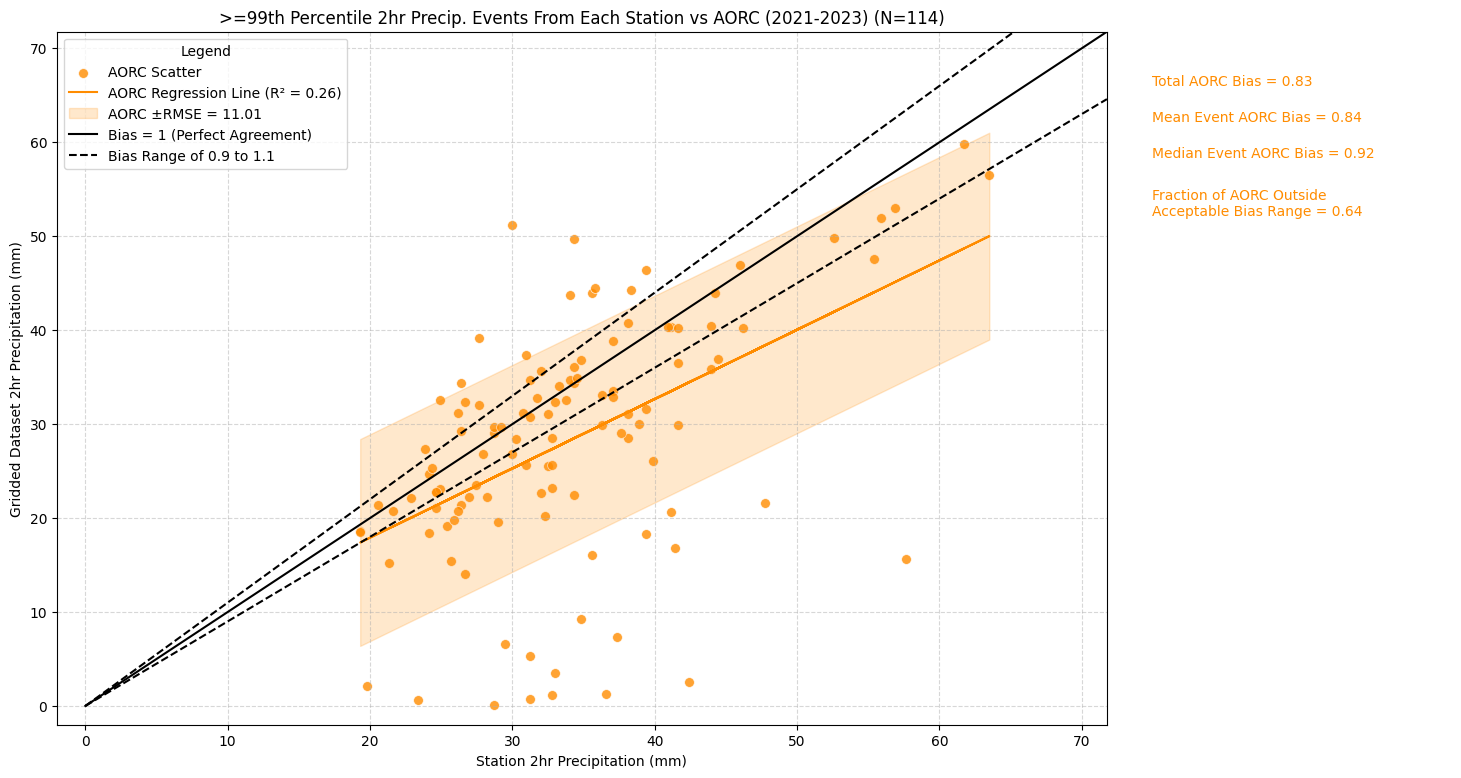

In [441]:
################################### Event Statistics #################################
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def combine_dataframes(dataframes_dict):
    """
    Combines multiple DataFrames from a dictionary into a single DataFrame.
    
    Parameters:
    - dataframes_dict: Dictionary where each value is a DataFrame to be combined.
    
    Returns:
    - A single concatenated DataFrame containing data from all input DataFrames.
    """
    # Extract all DataFrames from the dictionary values
    dataframes_list = list(dataframes_dict.values())
    
    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes_list, ignore_index=True)
    
    return combined_df

combined_df = combine_dataframes(full_dfs) # first combine all them into one dataframe

def plot_precipitation_scatter(df):
    """
    Plots scatter points comparing station precipitation amounts against the other datasets,
    with points color-coded differently for the two additional datasets.
    
    Parameters:
    - df: DataFrame containing columns 'accum_precip_2h', 'precip_ds1', and 'precip_ds2'.
    
    Returns:
    - None. Displays the plot.
    """
    # Create a figure with a designated area for the scatter plot and a text box
    fig, ax = plt.subplots(figsize=(15, 9))

    # Scatter plot using Seaborn
    sns.scatterplot(
        x=f'accum_precip_{hours}h',
        y='precip_aorc',
        data=df,
        label='AORC Scatter',
        color='darkorange',
        s=50,
        alpha=0.8,
        ax=ax
    )

    '''
    sns.scatterplot(
        x=f'accum_precip_{hours}h',
        y='precip_cmorph',
        data=df,
        label='CMORPH Scatter',
        color='red',
        s=50,
        alpha=0.8,
        ax=ax
    )
    '''

    # Linear regression using scikit-learn for Dataset 1
    model_ds1 = LinearRegression()
    model_ds1.fit(df[[f'accum_precip_{hours}h']], df['precip_aorc'])
    reg_line_ds1 = model_ds1.predict(df[[f'accum_precip_{hours}h']])
    r2_ds1 = r2_score(df['precip_aorc'], reg_line_ds1)
    
    # Plotting the regression line for Dataset 1
    ax.plot(df[f'accum_precip_{hours}h'], reg_line_ds1, color='darkorange', label=f'AORC Regression Line (R² = {r2_ds1:.2f})')

    # Calculate residuals and standard deviation for Dataset 1
    residuals_ds1 = df['precip_aorc'] - reg_line_ds1
    std_dev_ds1 = np.std(residuals_ds1)

    '''
    # Linear regression using scikit-learn for Dataset 2
    model_ds2 = LinearRegression()
    model_ds2.fit(df[[f'accum_precip_{hours}h']], df['precip_cmorph'])
    reg_line_ds2 = model_ds2.predict(df[[f'accum_precip_{hours}h']])
    r2_ds2 = r2_score(df['precip_cmorph'], reg_line_ds2)
    
    # Plotting the regression line for Dataset 2
    ax.plot(df[f'accum_precip_{hours}h'], reg_line_ds2, color='red', label=f'CMORPH Regression Line (R² = {r2_ds2:.2f})')

    # Calculate residuals and standard deviation for Dataset 2
    residuals_ds2 = df['precip_cmorph'] - reg_line_ds2
    std_dev_ds2 = np.std(residuals_ds2)
    '''

    # Plotting the standard deviation as filled contours for Dataset 1
    x_values = np.linspace(df[f'accum_precip_{hours}h'].min(), df[f'accum_precip_{hours}h'].max(), 100)
    x_values_df = pd.DataFrame(x_values, columns=[f'accum_precip_{hours}h'])  # Ensure feature names match
    reg_line_ds1_full = model_ds1.predict(x_values_df)
    ax.fill_between(x_values, reg_line_ds1_full - std_dev_ds1, reg_line_ds1_full + std_dev_ds1, 
                    color='darkorange', alpha=0.2, label=f'AORC ±RMSE = {std_dev_ds1:.2f}')

    '''
    # Plotting the standard deviation as filled contours for Dataset 2
    reg_line_ds2_full = model_ds2.predict(x_values_df)
    ax.fill_between(x_values, reg_line_ds2_full - std_dev_ds2, reg_line_ds2_full + std_dev_ds2, 
                    color='red', alpha=0.1, label=f'CMORPH ±RMSE = {std_dev_ds2:.2f}')
    '''
    # Set limits for the plot
    #max_ylim = max(df['precip_aorc'].max(), df['precip_cmorph'].max()) * 1.2
    max_ylim = max(df['precip_aorc']) * 1.2
    max_xlim = df[f'accum_precip_{hours}h'].max() + 20
    min_xlim = df[f'accum_precip_{hours}h'].min() - 20

    ax.set_xlim(-2, max_ylim)
    ax.set_ylim(-2, max_ylim)

    # Bias lines
    ax.plot([0, max_ylim], [0, max_ylim], color='black', label='Bias = 1 (Perfect Agreement)')
    ax.plot([0, max_ylim], [0, (max_ylim) * 0.9], color='black', linestyle='dashed', label='Bias Range of 0.9 to 1.1') # Bias = 0.9
    ax.plot([0, max_ylim], [0, max_ylim * 1.1], color='black', linestyle='dashed') # Bias = 1.1


    # Calculate biases and fractions outside acceptable range
    total_bias_a = df['precip_aorc'].sum() / df[f'accum_precip_{hours}h'].sum()
    #total_bias_c = df['precip_cmorph'].sum() / df[f'accum_precip_{hours}h'].sum()

    mean_event_bias_a = df['bias_aorc'].mean()
    #mean_event_bias_c = df['bias_cmorph'].mean()

    med_event_bias_a = df['bias_aorc'].median()
    #med_event_bias_c = df['bias_cmorph'].median()

    a_count = len(df.loc[(df['bias_aorc'] < 0.9) | (df['bias_aorc'] > 1.1)])/len(df)
    #c_count = len(df.loc[(df['bias_cmorph'] < 0.9) | (df['bias_cmorph'] > 1.1)])/len(df)

    # Add a new axes for the text box, positioned to the right of the main plot
    text_ax = plt.axes([0.78, 0.1, 0.2, 0.8])  # [left, bottom, width, height]
    text_ax.axis('off')  # Hide axes

    
    # Display bias information in the text box
    text_ax.text(0, 0.9, f'Total AORC Bias = {total_bias_a:.2f}', color='darkorange', fontsize=10)
    text_ax.text(0, 0.85, f'Mean Event AORC Bias = {mean_event_bias_a:.2f}', color='darkorange', fontsize=10)
    text_ax.text(0, 0.8, f'Median Event AORC Bias = {med_event_bias_a:.2f}', color='darkorange', fontsize=10)
    text_ax.text(0, 0.72, f'Fraction of AORC Outside \nAcceptable Bias Range = {a_count:.2f}', color='darkorange', fontsize=10)

    '''
    text_ax.text(0, 0.4, f'Total CMORPH Bias = {total_bias_c:.2f}', color='red', fontsize=10)
    text_ax.text(0, 0.35, f'Mean Event CMORPH Bias = {mean_event_bias_c:.2f}', color='red', fontsize=10)
    text_ax.text(0, 0.3, f'Median Event CMORPH Bias = {med_event_bias_c:.2f}', color='red', fontsize=10)
    text_ax.text(0, 0.22, f'Fraction of Events Outside \nAcceptable Bias Range = {c_count:.2f}', color='red', fontsize=10)
    '''

    # Set plot labels and title
    ax.set_xlabel(f'Station {hours}hr Precipitation (mm)')
    ax.set_ylabel(f'Gridded Dataset {hours}hr Precipitation (mm)')
    ax.set_title(f'>={percentile}th Percentile {hours}hr Precip. Events From Each Station vs AORC ({years[0]}-{years[-1]}) (N={len(df)})')

    # Add grid and legend
    ax.legend(loc='upper left', title='Legend')
    ax.grid(True, linestyle='--', alpha=0.5)

    #ax.set_facecolor('black')

    # Display the plot
    plt.subplots_adjust(left=0.05, right=0.75)
    #plt.tight_layout()
    plt.show()

    
plot_precipitation_scatter(combined_df)


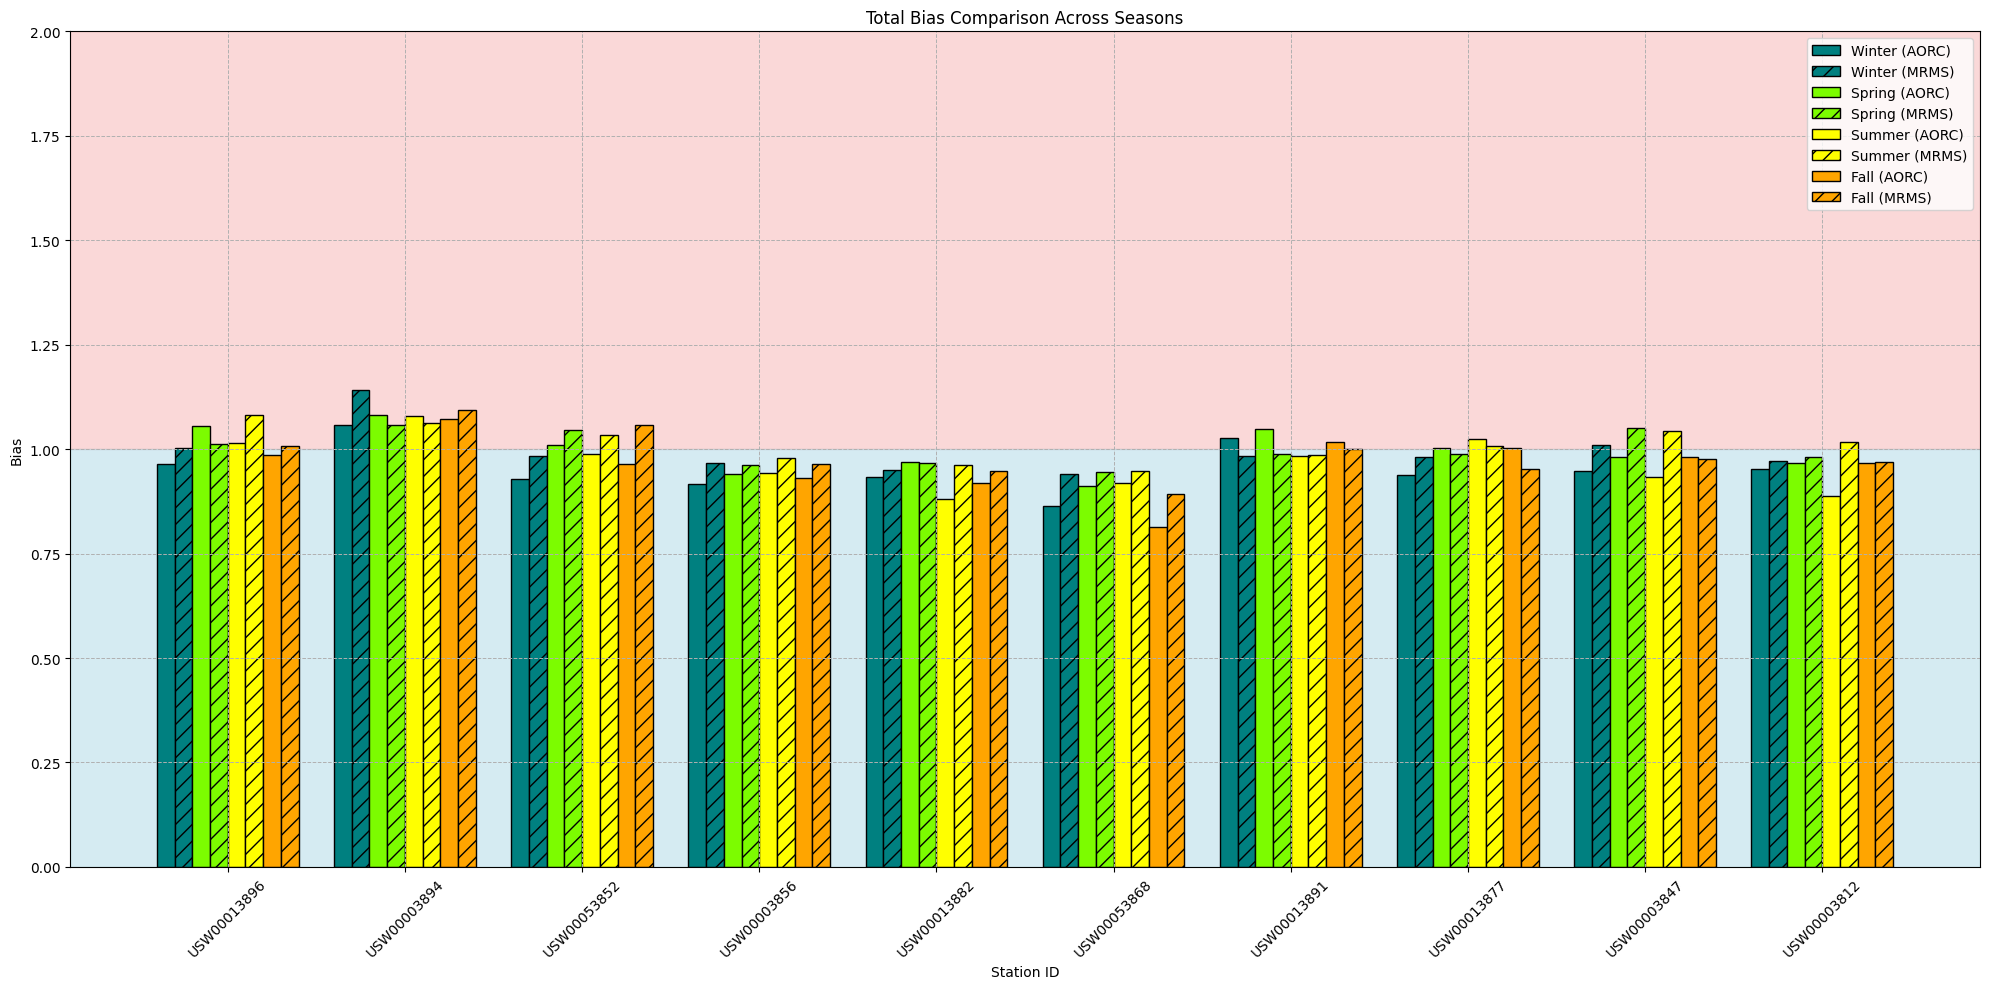

In [ ]:
# Function to plot bias comparison across all seasons
def plot_bias_comparison_all_seasons(dict1, dict2, bias_column):
    seasons = list(dict1.keys())
    station_ids = dict1[seasons[0]]['Station ID']  # Assuming all dataframes have the same stations

    # Set up bar width and x locations
    width = 0.10
    x = np.arange(len(station_ids))

    # Colors assigned to each season
    season_colors = {
        'Summer': 'yellow',
        'Winter': 'teal',
        'Spring': 'lawngreen',
        'Fall': 'orange'
    }

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for i, season in enumerate(seasons):
        data1 = dict1[season][bias_column]
        data2 = dict2[season][bias_column]
        
        # Bars for dict1 with season color
        ax.bar(x + i * 2 * width, data1, width, label=f'{season} (AORC)', color=season_colors[season], edgecolor='black')
        # Bars for dict2 with season color and hatch pattern
        ax.bar(x + i * 2 * width + width, data2, width, label=f'{season} (MRMS)', color=season_colors[season], hatch='//', edgecolor='black')
    
    # Adding labels and title
    ax.set_xlabel('Station ID')
    ax.set_ylabel('Bias')
    ax.set_title(f'{bias_column} Comparison Across Seasons')
    ax.set_xticks(x + width * (len(seasons) - 0.5))
    ax.set_xticklabels(station_ids, rotation=45)

    ax.set_ylim(0,2)

    # Get the current axis limits
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()

    # Color the region above y=0 in light red, ensuring it covers the whole area up to the plot's edges
    ax.fill_between(x_limits, 1, y_limits[1], color='lightcoral', alpha=0.3, zorder=-1)

    # Color the region below y=0 in light blue, ensuring it covers the whole area up to the plot's edges
    ax.fill_between(x_limits, y_limits[0], 1, color='lightblue', alpha=0.5, zorder=-1)

    # Ensure the plot limits don't change after the fill
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # Adding grid, legend, and tight layout
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)
    ax.legend(loc='upper right')
    plt.tight_layout()
    
    plt.show()
# Now let's plot for the '70-90% Bias' across all seasons
plot_bias_comparison_all_seasons(aorc_dfs, mrms_dfs, 'Total Bias')


In [334]:
mean_bias = []
lon = []
lat = []
ids = []
max_bias=[]
min_bias=[]
elv=[]
for station in full_dfs.keys():
    b = full_dfs[station]['bias_aorc'].mean()
    lati = station_datasets[station].latitude.values
    long = station_datasets[station].longitude.values
    elv1 = station_datasets[station].elevation.values
    max_bias.append(full_dfs[station]['bias_aorc'].max())
    min_bias.append(full_dfs[station]['bias_aorc'].min())
    lat.append(lati)
    lon.append(long)
    mean_bias.append(b)
    ids.append(station)
    elv.append(elv1)

mean_bias_df = pd.DataFrame(data = {'Station_ID ': ids, 'Longitude': lon, 'Latitude': lat, 'Elevation':elv, 'mean_bias': mean_bias, 'max_bias': max_bias, 'min_bias':min_bias})
print(mean_bias_df)


   Station_ID   Longitude  Latitude Elevation  mean_bias  max_bias  min_bias
0  USW00003812  -82.53787  35.43178    2118.0   0.985539  1.099550  0.937874
1  USW00003847  -85.08141  35.95097    1865.0   0.939332  1.052547  0.618979
2  USW00003856  -86.78615  34.64406     623.0   0.944405  1.161145  0.716367
3  USW00003894  -87.41174  36.61689     550.0   0.980573  1.125897  0.903051
4  USW00013877  -82.39893  36.47964    1496.0   0.972004  1.077574  0.898221
5  USW00013882  -85.20039  35.03363     669.0   0.953503  1.064056  0.847053
6  USW00013891  -83.98573  35.81801     971.0   1.024042  1.187086  0.964429
7  USW00013896  -87.59971  34.74388     544.0   1.117670  1.252562  0.979674
8  USW00053852  -86.94343  34.65798     588.0   1.057400  1.326288  0.892997
9  USW00053868   -84.2337    36.023     900.0   0.953468  1.059278  0.878625


In [336]:
########################## Mapping out the event analysis ################################
import matplotlib
from matplotlib.patches import Circle
from cartopy.geodesic import Geodesic
from matplotlib.patches import Polygon

clevs = [0.7,0.8,0.9,1.1,1.2,1.3]

# Set up the colormap and manually adjust colors to ensure 0.9 to 1.1 is white
colormap =  matplotlib.colormaps['seismic'] # Getting 'seismic' colormap
newcolors = colormap(np.linspace(0.25, 0.9, 6))  # Creates array of RGBA values from the colormap

# Adjust the colors between indices corresponding to 0.9 to 1.1 to be white
white_index_start = 2  # Index corresponding to the lower boundary (0.9)
white_index_end = 3    # Index corresponding to the upper boundary (1.1)
newcolors[white_index_start:white_index_end] = [1, 1, 1, 1]  # Setting color to white

# Create a new ListedColormap with the adjusted colors
cmap = mcolors.ListedColormap(newcolors)
norm = mcolors.BoundaryNorm(clevs, cmap.N)

cmap.set_under(colormap(np.linspace(0, 0.1, 1)))
cmap.set_over(colormap(np.linspace(0.99, 1, 1)))


def plot_bias_map(mean_bias_df, radar_metadata_df, plot_radars=True):

    # Set up the map
    fig, ax = plt.subplots(figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])  # Adjust the extent based on your station locations

    # Add features to the map
    ax.add_feature(cfeature.STATES, edgecolor='white', facecolor='black', zorder=-1)

    scatter = ax.scatter(mean_bias_df['Longitude'], mean_bias_df['Latitude'], c=mean_bias_df['mean_bias'], cmap=cmap, norm=norm, s=80, marker='o', edgecolor ='black', transform=ccrs.PlateCarree(), label='ACIS Stations')
    cbar = fig.colorbar(scatter, pad=0.05, extend='both', norm=norm).set_label('Bias')

    if plot_radars == True:
        nx = radar_metadata_df[radar_metadata_df['STNTYPE'] == 'NEXRAD']
        ax.scatter(nx['LON'], nx['LAT'], c='green', s=80, marker='^', edgecolor ='lime', transform=ccrs.PlateCarree(), label='NEXRAD Sites')
        tdwr = radar_metadata_df[radar_metadata_df['STNTYPE'] == 'TDWR']
        ax.scatter(tdwr['LON'], tdwr['LAT'], c='goldenrod', s=80, marker='^', edgecolor ='yellow', transform=ccrs.PlateCarree(), label='TDWR Sites')

        # Plot each station and its 50-mile circle
        for idx, row in nx.iterrows():
            lat = row['LAT']
            lon = row['LON']

            # Draw a 50-mile radius circle around each station
            geodesic = Geodesic()
            circle = geodesic.circle(lon=lon, lat=lat, radius=150000)  # radius in meters 
            # Create a filled polygon from the circle points
            poly = Polygon(circle, color='green', alpha=0.4, transform=ccrs.PlateCarree(), zorder=-1)  # Adjust alpha for transparency
            ax.add_patch(poly)

            #ax.plot(circle[:, 0], circle[:, 1], transform=ccrs.PlateCarree(), color='lime', linewidth=0.75, alpha=0.5)

        poly = Polygon(circle, color='green', alpha=0.3, transform=ccrs.PlateCarree(), zorder=-1, label='150km Radius')
        ax.add_patch(poly) # for the legend

        # tdwr radars as well
        for idx, row in tdwr.iterrows():
            lat = row['LAT']
            lon = row['LON']

            # Draw a 50-mile radius circle around each station
            geodesic = Geodesic()
            circle = geodesic.circle(lon=lon, lat=lat, radius=135000)  # radius in meters
            poly = Polygon(circle, color='yellow', alpha=0.2, transform=ccrs.PlateCarree(), zorder=-1)  # Adjust alpha for transparency
            #ax.add_patch(poly)
            #ax.plot(circle[:, 0], circle[:, 1], transform=ccrs.Geodetic(), color='yellow', linewidth=0.75, alpha=0.5)

        #ax.plot(circle[:, 0], circle[:, 1], transform=ccrs.Geodetic(), color='yellow', label='135km Radius', linewidth=1) # for the legend


    ax.set_title(f'CMORPH Mean Bias For >={percentile}th Percentile {hours}hr Precip. Events From Each Station ({years[0]}-{years[-1]})')

    ax.set_xticks(np.arange(-89, -81, 1), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(34, 38, 1), crs=ccrs.PlateCarree())
    ax.set_ylabel('Latitude')
    ax.set_xlabel('Longitude')
    ax.grid(True, linestyle='--', alpha=0.3)

    ax.legend(loc=0)

    plt.show()

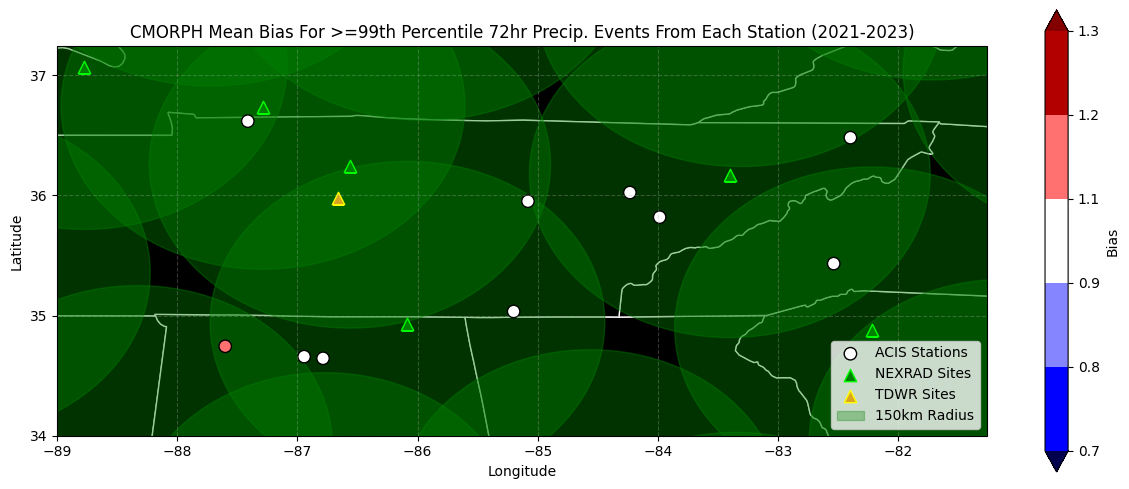

In [337]:
########################## Looking at distance from radar ##############################
# Define the file path
file_path = r"C:\Users\domenicbrooks\OneDrive - Research Triangle Institute\Documents\QPE_product_data\nexrad-stations.txt"

# Read the fixed-width file using pandas
radar_metadata_df = pd.read_fwf(
    file_path,
    skiprows=[1],  # Skip the second line with dashes
    header=0,    # Use the first line as the header
)

plot_bias_map(mean_bias_df, radar_metadata_df, plot_radars=True)

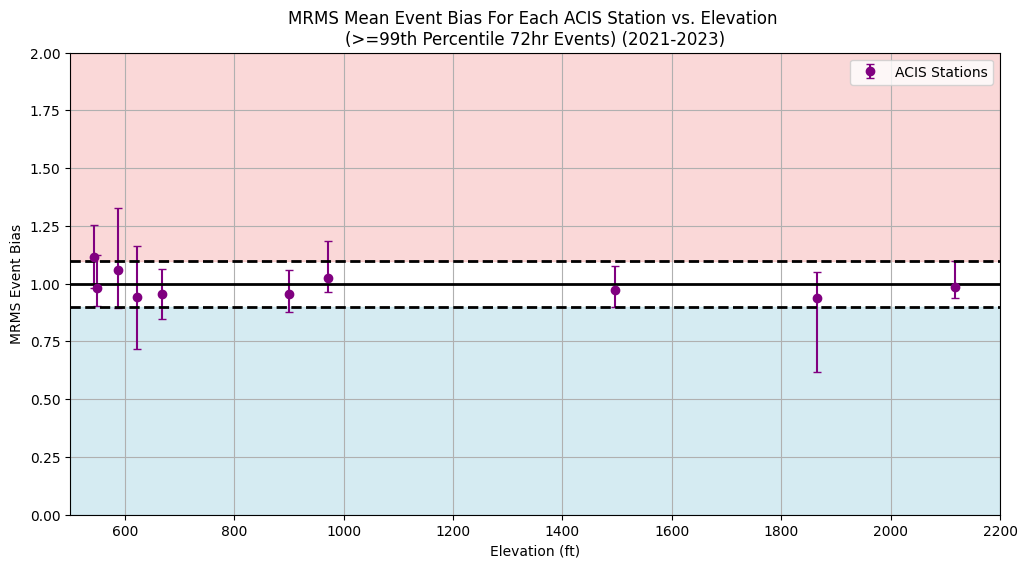

In [344]:
# Function to calculate Haversine distance between two points
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles. Adjust as needed.
    return c * r

# Calculate the closest NEXRAD station for each station in stations_df
distances = []

for idx, station in mean_bias_df.iterrows():
    lat1, lon1 = station['Latitude'], station['Longitude']
    # Calculate distances to all NEXRAD stations
    nexrad_distances = radar_metadata_df.apply(
        lambda row: haversine(lon1, lat1, row['LON'], row['LAT']),
        axis=1
    )
    # Find the minimum distance
    min_distance = nexrad_distances.min()
    distances.append(min_distance)

# Add the distances to the DataFrame
mean_bias_df['Distance_to_radar'] = distances

# Calculate the error values for the vertical error bars
mean_bias_df['error_min'] = mean_bias_df['mean_bias'] - mean_bias_df['min_bias']
mean_bias_df['error_max'] = mean_bias_df['max_bias'] - mean_bias_df['mean_bias']

# Plot mean_bias against distance to the closest radar station
plt.figure(figsize=(12, 6))


plt.errorbar(
    mean_bias_df['Elevation'], 
    mean_bias_df['mean_bias'], 
    yerr=[mean_bias_df['error_min'], mean_bias_df['error_max']], 
    fmt='o', 
    ecolor='purple', 
    capsize=3, 
    color='purple',
    label='ACIS Stations'
)

#plt.scatter(mean_bias_df['Distance_to_radar'], mean_bias_df['mean_bias'], color='purple', label='ACIS Stations')

# Color the region above y=0 in light red, ensuring it covers the whole area up to the plot's edges
plt.fill_between([500, 2200], 1.1, 2, color='lightcoral', alpha=0.3, zorder=-1)

# Color the region below y=0 in light blue, ensuring it covers the whole area up to the plot's edges
plt.fill_between([500, 2200], 0, 0.9, color='lightblue', alpha=0.5, zorder=-1)

plt.plot([500, 2200], [1,1], color='black', linewidth=2)
plt.plot([500, 2200], [1.1,1.1], color='black', linewidth=2, linestyle='dashed')
plt.plot([500, 2200], [0.9,0.9], color='black', linewidth=2, linestyle='dashed')

# Ensure the plot limits don't change after the fill
plt.xlim(500, 2200)
plt.ylim(0, 2)
plt.xlabel('Elevation (ft)')
plt.ylabel('MRMS Event Bias')
plt.title(f'MRMS Mean Event Bias For Each ACIS Station vs. Elevation \n(>={percentile}th Percentile {hours}hr Events) ({years[0]}-{years[-1]})')
plt.grid(True)
plt.legend(loc=0)
plt.show()

In [106]:
########################## Statistics for AORC vs Stations ###########################
from math import nan

def seasonal_bias(season):
    print(season)

    # dictionaries to store the values for each percentile regime
    aorc_90={}
    aorc_70={}
    aorc_50={}
    aorc_0={}

    station_90={}
    station_70={}
    station_50={}
    station_0={}

    rows=[]
    # Iterate through each dataset in the dictionary
    for key, dataset in station_datasets.items():
        ################################################## Getting the TOTAL Bias (no condiitons applied) ########################################################
        aorc_full=[]
        station_full=[]
        for year in years:
            if season == 'Winter' or season == 'winter':
                # Slices the aorc data and station data to get winter months
                aorc = aorc_datasets[key].sel(time=slice(pd.to_datetime(f'01-01-{year}'),pd.to_datetime(f'03-01-{year}')))
                aorc = xr.concat([aorc, aorc_datasets[key].sel(time=slice(pd.to_datetime(f'12-01-{year}'),pd.to_datetime(f'01-01-{year+1}')))], dim='time')
                aorc_full.append(aorc)

                station = dataset.sel(time=slice(pd.to_datetime(f'01-01-{year}'),pd.to_datetime(f'03-01-{year}')))
                station = xr.concat([station, dataset.sel(time=slice(pd.to_datetime(f'12-01-{year}'),pd.to_datetime(f'01-01-{year+1}')))], dim='time')
                station_full.append(station)

                percentiles = station_winter_percentiles[key] # assigns specified seasonal precip intensity percentile values
                print('winter')
            elif season == 'Spring' or season == 'spring':
                aorc = aorc_datasets[key].sel(time=slice(pd.to_datetime(f'03-01-{year}'),pd.to_datetime(f'06-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'03-01-{year}'),pd.to_datetime(f'06-01-{year}')))
                station_full.append(station)
                percentiles = station_spring_percentiles[key]
                print('spring')
            elif season == 'Summer' or season == 'summer':
                aorc = aorc_datasets[key].sel(time=slice(pd.to_datetime(f'06-01-{year}'),pd.to_datetime(f'09-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'06-01-{year}'),pd.to_datetime(f'09-01-{year}')))
                station_full.append(station)
                percentiles = station_summer_percentiles[key]
                print('summer')
            elif season == 'Fall' or season == 'fall':
                aorc = aorc_datasets[key].sel(time=slice(pd.to_datetime(f'09-01-{year}'),pd.to_datetime(f'12-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'09-01-{year}'),pd.to_datetime(f'12-01-{year}')))
                station_full.append(station)
                percentiles = station_fall_percentiles[key]
                print('fall')
            else:
                print('Please enter a valid season')

        # Merge the xarrays for each year 
        station = xr.merge(station_full)
        aorc2 = xr.merge(aorc_full)

        # Extract the sums across all available times
        sum_value_stations = station['Hourly Precip'].sum(dim='time').values
        aorc_sums = aorc2['APCP_surface'].sum(dim='time').values
        if aorc_sums !=0 and sum_value_stations !=0:
            aorc_bias = aorc_sums/sum_value_stations
        elif aorc_sums ==0 and sum_value_stations ==0:
            aorc_bias = 1
        elif aorc_sums !=0 and sum_value_stations ==0:
            aorc_bias = -1      
        elif aorc_sums ==0 and sum_value_stations !=0:
            aorc_bias = -2

        ################################################## Precip Intensity Biases ##################################################################################
        # Use logical indexing to create masks for stations data
        p0_50 = station['Hourly Precip'].where(station['Hourly Precip'] < percentiles[0], drop=True)
        p50_70 = station['Hourly Precip'].where((station['Hourly Precip'] >= percentiles[0]) & (station['Hourly Precip'] < percentiles[1]), drop=True)
        p70_90 = station['Hourly Precip'].where((station['Hourly Precip'] >= percentiles[1]) & (station['Hourly Precip'] < percentiles[-1]), drop=True)
        p90_100 = station['Hourly Precip'].where(station['Hourly Precip'] >= percentiles[-1], drop=True)


        #print(p90_100)
        #print(aorc)

         # Selects the aorc timesteps that match the station timesteps within each precip intensity

        p0_50_aorc = aorc2.sel(time=p0_50.time)
        p50_70_aorc = aorc2.sel(time=p50_70.time)
        p70_90_aorc = aorc2.sel(time=p70_90.time)
        p90_100_aorc = aorc2.sel(time=p90_100.time)

        #print(p0_50_aorc)

        # Flatten the arrays to get lists of values
        p0_50_station = p0_50.values.flatten().tolist()
        p50_70_station = p50_70.values.flatten().tolist()
        p70_90_station = p70_90.values.flatten().tolist()
        p90_100_station = p90_100.values.flatten().tolist()

        p0_50_aorc = p0_50_aorc['APCP_surface'].values.flatten().tolist()
        p50_70_aorc = p50_70_aorc['APCP_surface'].values.flatten().tolist()
        p70_90_aorc = p70_90_aorc['APCP_surface'].values.flatten().tolist()
        p90_100_aorc = p90_100_aorc['APCP_surface'].values.flatten().tolist()

        aorc_90[key] = p90_100_aorc
        aorc_70[key] = p70_90_aorc
        aorc_50[key] = p50_70_aorc
        aorc_0[key] = p0_50_aorc

        station_90[key] = p90_100_station
        station_70[key] = p70_90_station
        station_50[key] = p50_70_station
        station_0[key] = p0_50_station

        # Conditional statements to calculate biases for each precip intensity regime
        # Heavy
        not_equal = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p90_100_aorc) == len(p90_100_station):
            if len(p90_100_aorc) == 0 & len(p90_100_station) == 0:
                no_instances = True
                heavy_bias = nan
            else:
                heavy_bias = sum(p90_100_aorc)/sum(p90_100_station)
        else:
            not_equal = True
            heavy_bias = nan

        # Medium-Heavy
        not_equal2 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances2 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p70_90_aorc) == len(p70_90_station):
            if len(p70_90_aorc) == 0 & len(p70_90_station) == 0:
                no_instances2 = True
                med_heavy_bias = nan
            else:
                med_heavy_bias = sum(p70_90_aorc)/sum(p70_90_station)
        else:
            not_equal2 = True
            med_heavy_bias = nan

        # Medium
        not_equal3 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances3 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p50_70_aorc) == len(p50_70_station):
            if len(p50_70_aorc) == 0 & len(p50_70_station) == 0:
                no_instances3 = True
                med_bias = nan
            else:
                med_bias = sum(p50_70_aorc)/sum(p50_70_station)
        else:
            not_equal3 = True
            med_bias = nan

        # Light
        not_equal4 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances4 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p0_50_aorc) == len(p0_50_station):
            if len(p0_50_aorc) == 0 & len(p0_50_station) == 0:
                no_instances4 = True
                light_bias = nan
            else:
                if sum(p0_50_aorc) ==0 or sum(p0_50_station)==0:
                    light_bias= nan
                else:
                    light_bias = sum(p0_50_aorc)/sum(p0_50_station)
        else:
            not_equal4 = True
            light_bias = nan

        # Create a dictionary for the current row
        row = {
            'Station ID': key,
            'Total Bias': aorc_bias, # scaled from 0 now (+ is over, - is under) 
            '0-50% Bias': light_bias,
            '50-70% Bias': med_bias,
            '70-90% Bias': med_heavy_bias,
            '90-100% Bias': heavy_bias,
            'Total Sample #': len(dataset.time.values),
            'Sample # AORC 0-50': len(p0_50_aorc), # sample size per precip regime
            'Sample # Station 0-50': len(p0_50_station),
            'Sample # AORC 50-70': len(p50_70_aorc),
            'Sample # Station 50-70': len(p50_70_station),
            'Sample # AORC 70-90': len(p70_90_aorc),
            'Sample # Station 70-90': len(p70_90_station),
            'Sample # AORC 90-100': len(p90_100_aorc),
            'Sample # Station 90-100': len(p90_100_station),
            'Elevation': dataset.elevation.values
        }
        # Append the dictionary to the list
        rows.append(row)
        
    bias_df = pd.DataFrame(rows).sort_values('Elevation',ascending=True)

    return bias_df, aorc_0, aorc_50, aorc_70, aorc_90, station_0, station_50, station_70, station_90

season='Fall'
a_bias_df, aorc_0, aorc_50, aorc_70, aorc_90, station_0, station_50, station_70, station_90 = seasonal_bias(season)

Fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall


In [107]:
aorc_bias_df = a_bias_df[['Station ID',	'Total Bias',	'0-50% Bias',	'50-70% Bias',	'70-90% Bias',	'90-100% Bias','Elevation']].sort_values('Elevation',ascending=True)
a_bias_df

,Station ID,Total Bias,0-50% Bias,50-70% Bias,70-90% Bias,90-100% Bias,Total Sample #,Sample # AORC 0-50,Sample # Station 0-50,Sample # AORC 50-70,Sample # Station 50-70,Sample # AORC 70-90,Sample # Station 70-90,Sample # AORC 90-100,Sample # Station 90-100,Elevation
7,USW00013896,1.017536,1.375084,1.175188,1.087903,0.874133,10874,1165,1165,438,438,470,470,248,248,544.0
3,USW00003894,0.980058,1.194275,1.105044,1.045153,0.868918,11076,1376,1376,372,372,566,566,259,259,550.0
8,USW00053852,1.067294,1.235754,1.182066,1.135186,0.976344,10451,1205,1205,334,334,480,480,247,247,588.0
2,USW00003856,0.994356,1.329886,1.075229,1.004414,0.905154,10388,1014,1014,591,591,358,358,234,234,623.0
5,USW00013882,0.964052,1.165744,1.042118,0.971038,0.901291,11078,1090,1090,633,633,508,508,247,247,669.0
9,USW00053868,0.980868,1.286844,1.050502,1.048666,0.855262,12331,1229,1229,546,546,599,599,283,283,900.0
6,USW00013891,1.014996,1.285397,1.087352,1.018094,0.930018,11713,1228,1228,581,581,512,512,272,272,971.0
4,USW00013877,0.991797,1.206154,0.998430,0.999755,0.913030,12084,1343,1343,493,493,498,498,271,271,1496.0
1,USW00003847,0.978040,1.038372,1.084445,1.013262,0.916336,13579,1604,1604,452,452,696,696,309,309,1865.0
0,USW00003812,0.965835,1.087396,1.080372,1.009116,0.868961,12335,1402,1402,625,625,599,599,300,300,2118.0


In [47]:
########################################### Function for Density Plots (No conditions) ###################################
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

def plot_density_full(gridded_dataset): # input either 'aorc', 'cmorph, or 'both'
    fig, axes = plt.subplots(2, 6, figsize=(21, 11), sharex=False, sharey=False)
    i = 0
    for key, dataset in station_datasets.items():
        if gridded_dataset == 'aorc':
            x = dataset['Hourly Precip'].values
            y = aorc_datasets[key]['APCP_surface'].values
            title1 = 'Station'
            title2 = 'AORC'
        elif gridded_dataset == 'cmorph':
            x = dataset['Hourly Precip'].values
            y = cmorph_datasets[key]['cmorph'].values
            title1 = 'Station'
            title2 = 'CMORPH'
        elif gridded_dataset == 'mrms':
            x = dataset['Hourly Precip'].values
            y = mrms_datasets[key]['unknown'].values
            title1 = 'Station'
            title2 = 'MRMS'
        elif gridded_dataset == 'both':
            x = aorc_datasets[key]['APCP_surface'].values
            y = mrms_datasets[key]['unknown'].values
            title1 = 'AORC'
            title2 = 'MRMS'

        row = i // 6
        col = i % 6
        #print(aorc_datasets[key])

        
        # Convert inf values to NaN
        x[np.isinf(x)] = np.nan
        y[np.isinf(y)] = np.nan

        #print(len(x) , len(y))
        # Check for NaN values
        if np.any(np.isnan(y)):
            print('nan values detected')
        
        ax = axes[row, col]

        xlim1 = max(x) + 5
        ylim1 = max(y) + 5               

        # Define logarithmic bins
        log_bins = np.logspace(np.log10(0.25), np.log10(64), 30)
    
        # Create 2D histogram with logarithmic bins
        clevs = [0, 5, 10, 20, 40, 80]
        cmap = mpl.colormaps['viridis']
        cmap = mcolors.ListedColormap(cmap(np.linspace(0, 0.85, 6)))
        norm = mcolors.BoundaryNorm(clevs, cmap.N) #normalizes the bounds for the color mapping
        cmap.set_over('yellow')

        hb = ax.hist2d(x, y, bins=[log_bins, log_bins], cmap=cmap, cmin=1, norm=norm)
        

        # Fit linear regression using the original x and y data
        reg = LinearRegression().fit(x.reshape(-1, 1), y)

        # Get the regression line's predictions
        x_vals = np.linspace(min(x), max(x), 100)  # Generate 100 points from min to max of x
        y_vals = reg.predict(x_vals.reshape(-1, 1))  # Predict corresponding y-values

        # Plot the regression line on top of the 2D histogram
        ax.plot(x_vals, y_vals, color='red', label='Lin. Reg.', linestyle='dashed', linewidth=3)
        
        # Calculate the R^2 value
        y_pred = reg.predict(x.reshape(-1, 1))
        r_squared = r2_score(y, y_pred)
        
        # pearson correlation
        r = stats.pearsonr(x,y).statistic

        # Set both axes to logarithmic scale
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Set custom ticks to ensure uniform spacing on the plot
        custom_ticks = [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
        ax.set_xticks(custom_ticks)
        ax.set_yticks(custom_ticks)

        # Label the ticks accordingly
        ax.set_xticklabels([str(tick) for tick in custom_ticks])
        ax.set_yticklabels([str(tick) for tick in custom_ticks])
        ax.minorticks_off()

        # Plot the line with a slope of 1
        max_limit = max(max(x), max(y)) + 5
        ax.plot([0, max_limit], [0, max_limit], color='black')
        ax.text(0.35, 45, r'$R^2$ Fit' + f' = {r_squared:.2f}', fontsize=10)
        ax.text(0.35, 37, f'Pearson r = {r:.2f}', fontsize=10)

        import warnings

        # Suppress warnings about the axis limits
        warnings.filterwarnings("ignore", category=UserWarning)
        ax.set_xlim(0, 64)
        ax.set_ylim(0, 64)

        ax.set_title('Station {0}'.format(key), fontsize=10)
        ax.legend(loc=0)

        ax.set_facecolor('lightgray')

        i += 1

    # Adjustments for colorbar and labels
    fig.text(0.5, 0.01, f'{title1} Collocated Precip (mm/hr)', ha='center', va='center', fontsize=14)
    fig.text(0.01, 0.5, f'{title2} Collocated Precip (mm/hr)', ha='center', va='center', rotation='vertical', fontsize=14)
    fig.suptitle(f'{title1} vs {title2} {years[0]}-{years[-1]}') # x vs. y

    # Colorbar for the entire figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(hb[3], cax=cbar_ax, pad=0.1, extend='max').set_label('Instances')
    hb[3].set_clim(0, 100)
    # Adjust spacing between subplots and around the figure
    plt.subplots_adjust(left=0.05, right=0.9, top=0.92, bottom=0.05, wspace=0.2, hspace=0.2)

    plt.show()


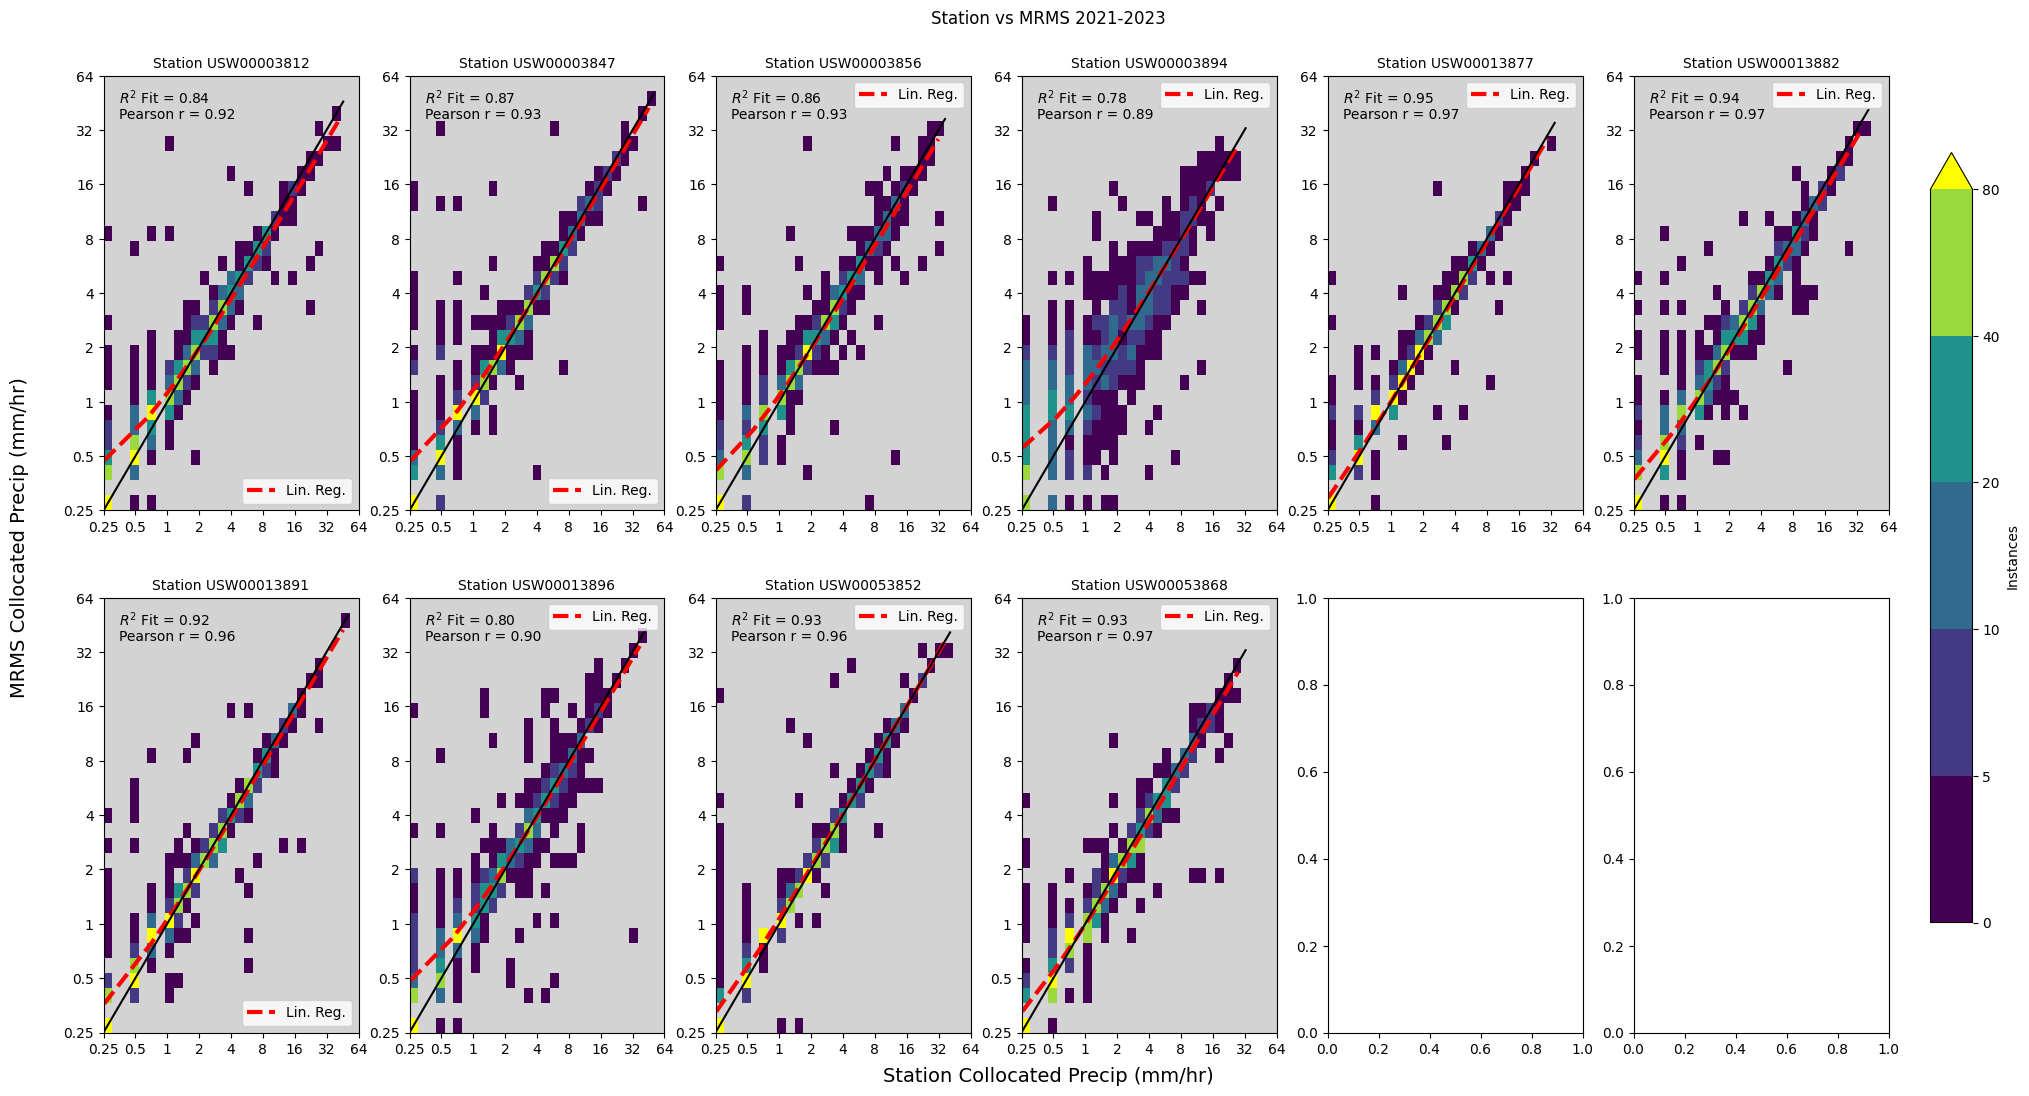

In [379]:
plot_density_full(gridded_dataset='mrms')

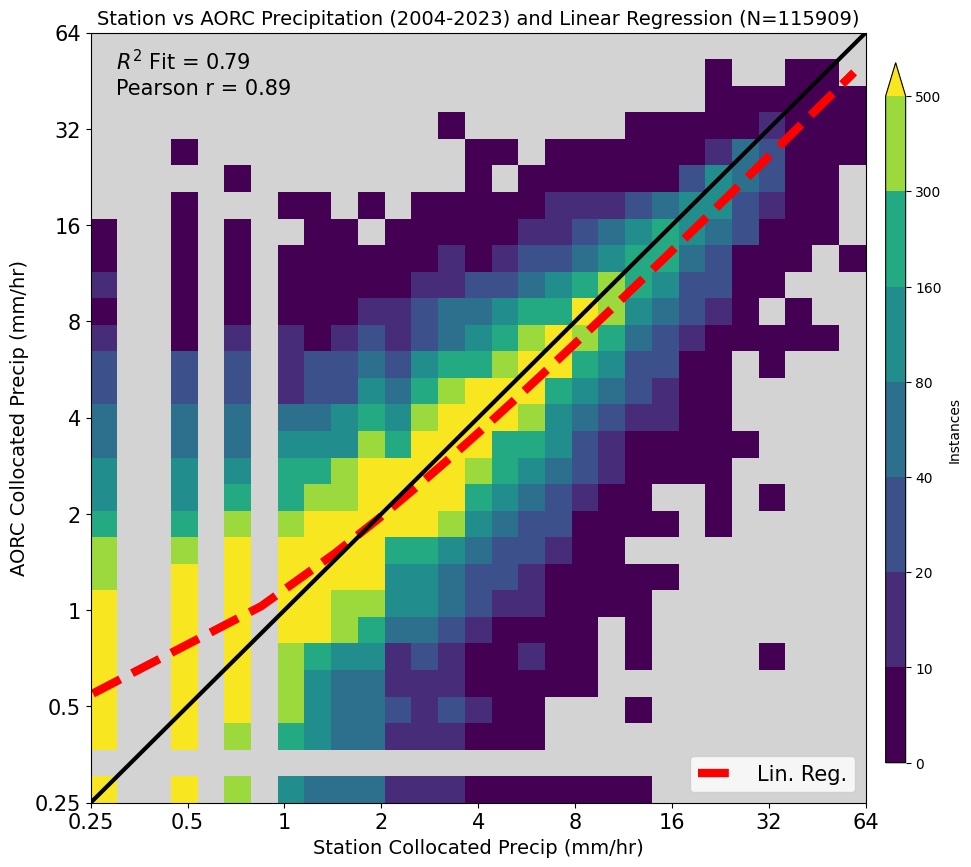

In [135]:
############### Plot density (all stations combined) ###############
def plot_density_full2(gridded_dataset):
    gridded_data=[]
    station_data=[]
    for key, dataset in station_datasets.items():
            if gridded_dataset == 'aorc':
                x = dataset['Hourly Precip'].values
                y = aorc_datasets[key]['APCP_surface'].values
                title1 = 'Station'
                title2 = 'AORC'
                gridded_data.extend(y)
                station_data.extend(x)
            elif gridded_dataset == 'cmorph':
                x = dataset['Hourly Precip'].values
                y = cmorph_datasets[key]['cmorph'].values
                title1 = 'Station'
                title2 = 'CMORPH'
                gridded_data.extend(y)
                station_data.extend(x)
            elif gridded_dataset == 'mrms':
                x = dataset['Hourly Precip'].values
                y = mrms_datasets[key]['unknown'].values
                title1 = 'Station'
                title2 = 'MRMS'
                gridded_data.extend(y)
                station_data.extend(x)
            elif gridded_dataset == 'both':
                x = aorc_datasets[key]['APCP_surface'].values
                y = mrms_datasets[key]['unknown'].values
                title1 = 'AORC'
                title2 = 'MRMS'
                gridded_data.extend(y)
                station_data.extend(x)

    gridded_data = np.array(gridded_data)
    station_data = np.array(station_data)

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()

    # Define logarithmic bins
    log_bins = np.logspace(np.log10(0.25), np.log10(64), 30)

    # Create 2D histogram with logarithmic bins
    clevs = [0, 10, 20, 40, 80, 160, 300, 500]
    cmap1 = mpl.colormaps['viridis']
    cmap = mcolors.ListedColormap(cmap1(np.linspace(0, 0.85, len(clevs))))
    norm = mcolors.BoundaryNorm(clevs, cmap.N) #normalizes the bounds for the color mapping
    cmap.set_over(cmap1(np.linspace(0.99, 1, 1)))
    #cmap.set_over('yellow')

    hb = ax.hist2d(station_data, gridded_data, bins=[log_bins, log_bins], cmap=cmap, cmin=1, norm=norm)
    

    # Fit linear regression using the original x and y data
    reg = LinearRegression().fit(station_data.reshape(-1, 1), gridded_data)

    # Get the regression line's predictions
    x_vals = np.linspace(min(station_data), max(station_data), 100)  # Generate 100 points from min to max of x
    y_vals = reg.predict(x_vals.reshape(-1, 1))  # Predict corresponding y-values

    # Plot the regression line on top of the 2D histogram
    ax.plot(x_vals, y_vals, color='red', label='Lin. Reg.', linestyle='dashed', linewidth=6)
    
    # Calculate the R^2 value
    y_pred = reg.predict(station_data.reshape(-1, 1))
    r_squared = r2_score(gridded_data, y_pred)
    
    # pearson correlation
    r = stats.pearsonr(station_data,gridded_data).statistic

    # Set both axes to logarithmic scale
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set custom ticks to ensure uniform spacing on the plot
    custom_ticks = [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
    ax.set_xticks(custom_ticks)
    ax.set_yticks(custom_ticks)

    # Label the ticks accordingly
    ax.set_xticklabels([str(tick) for tick in custom_ticks], fontsize=15)
    ax.set_yticklabels([str(tick) for tick in custom_ticks], fontsize=15)
    ax.minorticks_off()

    # Plot the line with a slope of 1
    max_limit = max(max(station_data), max(gridded_data)) + 5
    ax.plot([0, max_limit], [0, max_limit], color='black', linewidth=3)
    ax.text(0.3, 49, r'$R^2$ Fit' + f' = {r_squared:.2f}', fontsize=15)
    ax.text(0.3, 41, f'Pearson r = {r:.2f}', fontsize=15)

    import warnings

    # Suppress warnings about the axis limits
    warnings.filterwarnings("ignore", category=UserWarning)
    ax.set_xlim(0, 64)
    ax.set_ylim(0, 64)

    #ax.set_title('Station {0}'.format(key), fontsize=10)
    ax.legend(loc=0, fontsize=15)

    ax.set_facecolor('lightgray')

    ax.set_xlabel(f'{title1} Collocated Precip (mm/hr)', fontsize=14)
    ax.set_ylabel(f'{title2} Collocated Precip (mm/hr)', fontsize=14)
    ax.set_title(f'{title1} vs {title2} Precipitation (2004-2023) and Linear Regression (N={len(gridded_data)})', fontsize=14) # x vs. y

    # Colorbar for the entire figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(hb[3], cax=cbar_ax, pad=0.1, extend='max').set_label('Instances')
    hb[3].set_clim(0, max(clevs))

    plt.show()
        
plot_density_full2(gridded_dataset='aorc')

In [ ]:
########################################### AORC Density Plots (By Preip Intensity Percentile) ###################################
from sklearn.metrics import r2_score
import seaborn as sns
def plot_density_by_intensity(aorc_intensity, station_intensity): # input the dictionaries of the desired precip intensity regimes (e.g aorc_0, station_0)
    fig, axes = plt.subplots(2, 6, figsize=(20, 10), sharex=False, sharey=False)

    if aorc_intensity == aorc_0:
        fig.suptitle(f'0-50th Percentile Desnity plot for {season}')
        column = '0-50% Bias'
    elif aorc_intensity == aorc_50:
        fig.suptitle(f'50-70th Percentile Desnity plot for {season}')
        column = '50-70% Bias'
    elif aorc_intensity == aorc_70:
        fig.suptitle(f'70-90th Percentile Desnity plot for {season}')
        column = '70-90% Bias'
    elif aorc_intensity == aorc_90:
        fig.suptitle(f'90-100th Percentile Desnity plot for {season}')
        column = '90-100% Bias'

    i = 0
    for key, dataset in station_intensity.items():
        x = np.array(dataset)
        y = aorc_intensity[key]
        row = i // 6
        col = i % 6
        #print(aorc_datasets[key])
        
        ax = axes[row, col]              

        #bins = int(np.floor(max(max(x), max(y)) / 2))
        #print(bins)
        norm = mcolors.Normalize(vmin=0, vmax=25)
        hb = ax.hist2d(x, y, bins=10, cmap='viridis', cmin=1, norm=norm)

         # Fit linear regression using the original x and y data
        reg = LinearRegression().fit(x.reshape(-1, 1), y)

        # Get the regression line's predictions
        x_vals = np.linspace(min(x), max(x), 100)  # Generate 100 points from min to max of x
        y_vals = reg.predict(x_vals.reshape(-1, 1))  # Predict corresponding y-values

        # Plot the regression line on top of the 2D histogram
        ax.plot(x_vals, y_vals, color='red', label='Lin. Reg.', linestyle='dashed')
        
        # Calculate R-squared value
        r_squared = r2_score(y, x)

        n_value = len(x) # sample size

        bias = aorc_bias_df.loc[aorc_bias_df['Station ID'] == key, column].values[0]

        # Plot the line with a slope of 1
        max_limit = max(max(x), max(y)) + 1
        ax.plot([0, max_limit], [0, max_limit], color='black')
        ax.text(station_fall_percentiles[key][-1] * 0.05, max_limit * 0.9, r'$R^2$' + f' = {r_squared:.2f}', fontsize=10)
        ax.text(station_fall_percentiles[key][-1] * 0.05, max_limit * 0.85, f'N={n_value:.0f}', fontsize=8)
        ax.text(station_fall_percentiles[key][-1] * 0.05, max_limit * 0.82, f'Bias={bias:.2f}', fontsize=8)
        ax.set_xlim(0, 50)
        ax.set_ylim(0, max_limit)

        ax.set_title('Station {0}'.format(key), fontsize=10)

        i += 1

    # Adjustments for colorbar and labels
    fig.text(0.5, 0.01, 'Station Precip (mm/hr)', ha='center', va='center', fontsize=14)
    fig.text(0.01, 0.5, 'AORC Collocated Precip (mm/hr)', ha='center', va='center', rotation='vertical', fontsize=14)

    # Colorbar for the entire figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(hb[3], cax=cbar_ax, pad=0.1, extend='max').set_label('Instances')
    hb[3].set_clim(0, 25)
    # Adjust spacing between subplots and around the figure
    plt.subplots_adjust(left=0.05, right=0.9, top=0.92, bottom=0.05, wspace=0.2, hspace=0.2)

    plt.show()

plot_density_by_intensity(aorc_90, station_90)

In [87]:
################################### Statistics for CMORPH ####################################

def cmorph_seasonal_bias(season):
    print(season)

    # dictionaries to store the values for each percentile regime
    cmorph_90={}
    cmorph_70={}
    cmorph_50={}
    cmorph_0={}

    station_90={}
    station_70={}
    station_50={}
    station_0={}

    rows=[]
    # Iterate through each dataset in the dictionary
    for key, dataset in station_datasets.items():
        ################################################## Getting the TOTAL Bias (no condiitons applied) ########################################################
        aorc_full=[]
        station_full=[]
        for year in years:
            if season == 'Winter' or season == 'winter':
                # Slices the aorc data and station data to get winter months
                aorc = cmorph_datasets[key].sel(time=slice(pd.to_datetime(f'01-01-{year}'),pd.to_datetime(f'03-01-{year}')))
                aorc = xr.concat([aorc, cmorph_datasets[key].sel(time=slice(pd.to_datetime(f'12-01-{year}'),pd.to_datetime(f'01-01-{year+1}')))], dim='time')
                aorc_full.append(aorc)
                #print(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'01-01-{year}'),pd.to_datetime(f'03-01-{year}')))
                station = xr.concat([station, dataset.sel(time=slice(pd.to_datetime(f'12-01-{year}'),pd.to_datetime(f'01-01-{year+1}')))], dim='time')
                station_full.append(station)

                percentiles = station_winter_percentiles[key] # assigns specified seasonal precip intensity percentile values
                print('winter')
            elif season == 'Spring' or season == 'spring':
                aorc = cmorph_datasets[key].sel(time=slice(pd.to_datetime(f'03-01-{year}'),pd.to_datetime(f'06-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'03-01-{year}'),pd.to_datetime(f'06-01-{year}')))
                station_full.append(station)
                percentiles = station_spring_percentiles[key]
                print('spring')
            elif season == 'Summer' or season == 'summer':
                aorc = cmorph_datasets[key].sel(time=slice(pd.to_datetime(f'06-01-{year}'),pd.to_datetime(f'09-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'06-01-{year}'),pd.to_datetime(f'09-01-{year}')))
                station_full.append(station)
                percentiles = station_summer_percentiles[key]
                print('summer')
            elif season == 'Fall' or season == 'fall':
                aorc = cmorph_datasets[key].sel(time=slice(pd.to_datetime(f'09-01-{year}'),pd.to_datetime(f'12-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'09-01-{year}'),pd.to_datetime(f'12-01-{year}')))
                station_full.append(station)
                percentiles = station_fall_percentiles[key]
                print('fall')
            else:
                print('Please enter a valid season')

        # Merge the xarrays for each year 
        station = xr.merge(station_full)
        aorc2 = xr.merge(aorc_full)

        # Extract the sums across all available times
        sum_value_stations = station['Hourly Precip'].sum(dim='time').values
        aorc_sums = aorc2['cmorph'].sum(dim='time').values
        if aorc_sums !=0 and sum_value_stations !=0:
            aorc_bias = aorc_sums/sum_value_stations
        elif aorc_sums ==0 and sum_value_stations ==0:
            aorc_bias = 1
        elif aorc_sums !=0 and sum_value_stations ==0:
            aorc_bias = -1      
        elif aorc_sums ==0 and sum_value_stations !=0:
            aorc_bias = -2

        ################################################## Precip Intensity Biases ##################################################################################
        # Use logical indexing to create masks for stations data
        p0_50 = station['Hourly Precip'].where(station['Hourly Precip'] < percentiles[0], drop=True)
        p50_70 = station['Hourly Precip'].where((station['Hourly Precip'] >= percentiles[0]) & (station['Hourly Precip'] < percentiles[1]), drop=True)
        p70_90 = station['Hourly Precip'].where((station['Hourly Precip'] >= percentiles[1]) & (station['Hourly Precip'] < percentiles[-1]), drop=True)
        p90_100 = station['Hourly Precip'].where(station['Hourly Precip'] >= percentiles[-1], drop=True)


        #print(p90_100)
        #print(aorc)

         # Selects the aorc timesteps that match the station timesteps within each precip intensity

        p0_50_aorc = aorc2.sel(time=p0_50.time)
        p50_70_aorc = aorc2.sel(time=p50_70.time)
        p70_90_aorc = aorc2.sel(time=p70_90.time)
        p90_100_aorc = aorc2.sel(time=p90_100.time)

        #print(p0_50_aorc)

        # Flatten the arrays to get lists of values
        p0_50_station = p0_50.values.flatten().tolist()
        p50_70_station = p50_70.values.flatten().tolist()
        p70_90_station = p70_90.values.flatten().tolist()
        p90_100_station = p90_100.values.flatten().tolist()

        p0_50_aorc = p0_50_aorc['cmorph'].values.flatten().tolist()
        p50_70_aorc = p50_70_aorc['cmorph'].values.flatten().tolist()
        p70_90_aorc = p70_90_aorc['cmorph'].values.flatten().tolist()
        p90_100_aorc = p90_100_aorc['cmorph'].values.flatten().tolist()

        cmorph_90[key] = p90_100_aorc
        cmorph_70[key] = p70_90_aorc
        cmorph_50[key] = p50_70_aorc
        cmorph_0[key] = p0_50_aorc

        station_90[key] = p90_100_station
        station_70[key] = p70_90_station
        station_50[key] = p50_70_station
        station_0[key] = p0_50_station

        # Conditional statements to calculate biases for each precip intensity regime
        # Heavy
        not_equal = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p90_100_aorc) == len(p90_100_station):
            if len(p90_100_aorc) == 0 & len(p90_100_station) == 0:
                no_instances = True
                heavy_bias = nan
            else:
                heavy_bias = sum(p90_100_aorc)/sum(p90_100_station)
        else:
            not_equal = True
            heavy_bias = nan

        # Medium-Heavy
        not_equal2 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances2 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p70_90_aorc) == len(p70_90_station):
            if len(p70_90_aorc) == 0 & len(p70_90_station) == 0:
                no_instances2 = True
                med_heavy_bias = nan
            else:
                med_heavy_bias = sum(p70_90_aorc)/sum(p70_90_station)
        else:
            not_equal2 = True
            med_heavy_bias = nan

        # Medium
        not_equal3 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances3 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p50_70_aorc) == len(p50_70_station):
            if len(p50_70_aorc) == 0 & len(p50_70_station) == 0:
                no_instances3 = True
                med_bias = nan
            else:
                med_bias = sum(p50_70_aorc)/sum(p50_70_station)
        else:
            not_equal3 = True
            med_bias = nan

        # Light
        not_equal4 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances4 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p0_50_aorc) == len(p0_50_station):
            if len(p0_50_aorc) == 0 & len(p0_50_station) == 0:
                no_instances4 = True
                light_bias = nan
            else:
                if sum(p0_50_aorc) ==0 or sum(p0_50_station)==0:
                    light_bias= nan
                else:
                    light_bias = sum(p0_50_aorc)/sum(p0_50_station)
        else:
            not_equal4 = True
            light_bias = nan

        # Create a dictionary for the current row
        row = {
            'Station ID': key,
            'Total Bias': aorc_bias,
            '0-50% Bias': light_bias,
            '50-70% Bias': med_bias,
            '70-90% Bias': med_heavy_bias,
            '90-100% Bias': heavy_bias,
            'Total Sample #': len(dataset.time.values),
            'Sample # CMORPH 0-50': len(p0_50_aorc), # sample size per precip regime
            'Sample # Station 0-50': len(p0_50_station),
            'Sample # CMORPH 50-70': len(p50_70_aorc),
            'Sample # Station 50-70': len(p50_70_station),
            'Sample # CMORPH 70-90': len(p70_90_aorc),
            'Sample # Station 70-90': len(p70_90_station),
            'Sample # CMORPH 90-100': len(p90_100_aorc),
            'Sample # Station 90-100': len(p90_100_station),
            'Elevation': dataset.elevation.values
        }
        # Append the dictionary to the list
        rows.append(row)
        
    bias_df = pd.DataFrame(rows).sort_values('Elevation',ascending=True)

    return bias_df, cmorph_0, cmorph_50, cmorph_70, cmorph_90, station_0, station_50, station_70, station_90

#season='Fall'
c_bias_df, cmorph_0, cmorph_50, cmorph_70, cmorph_90, station_0, station_50, station_70, station_90 = cmorph_seasonal_bias(season)

Fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall


In [116]:
cmorph_bias_df = c_bias_df[['Station ID',	'Total Bias',	'0-50% Bias',	'50-70% Bias',	'70-90% Bias',	'90-100% Bias','Elevation']].sort_values('Elevation',ascending=True)
cmorph_bias_df

,Station ID,Total Bias,0-50% Bias,50-70% Bias,70-90% Bias,90-100% Bias,Elevation
7,USW00013896,0.680453,1.773396,0.980940,0.792748,0.343224,544.0
3,USW00003894,0.603170,1.686254,0.902940,0.593951,0.323653,550.0
8,USW00053852,0.695922,1.755678,1.230014,0.753093,0.360673,588.0
2,USW00003856,0.588813,1.793278,0.871782,0.589982,0.288855,623.0
5,USW00013882,0.636330,1.937138,1.012789,0.622943,0.313674,669.0
9,USW00053868,0.649276,1.738409,0.996376,0.649232,0.346559,900.0
6,USW00013891,0.724198,1.775810,1.033804,0.739997,0.381991,971.0
4,USW00013877,0.677688,1.561633,0.802388,0.693063,0.331581,1496.0
1,USW00003847,0.680240,1.493806,1.255218,0.666276,0.379653,1865.0
0,USW00003812,0.721029,1.844330,0.932174,0.673575,0.423775,2118.0


In [103]:
############################################# MRMS Statistics ########################################

def mrms_seasonal_bias(season):
    print(season)
    years = np.arange(2021,2024,1)
    # dictionaries to store the values for each percentile regime
    aorc_90={}
    aorc_70={}
    aorc_50={}
    aorc_0={}

    station_90={}
    station_70={}
    station_50={}
    station_0={}

    rows=[]
    # Iterate through each dataset in the dictionary
    for key, dataset in station_datasets.items():
        ################################################## Getting the TOTAL Bias (no condiitons applied) ########################################################
        aorc_full=[]
        station_full=[]
        for year in years:
            if season == 'Winter' or season == 'winter':
                # Slices the mrms data and station data to get winter months
                aorc = mrms_datasets[key].sel(time=slice(pd.to_datetime(f'01-01-{year}'),pd.to_datetime(f'03-01-{year}')))
                aorc = xr.concat([aorc, mrms_datasets[key].sel(time=slice(pd.to_datetime(f'12-01-{year}'),pd.to_datetime(f'01-01-{year+1}')))], dim='time')
                aorc_full.append(aorc)

                station = dataset.sel(time=slice(pd.to_datetime(f'01-01-{year}'),pd.to_datetime(f'03-01-{year}')))
                station = xr.concat([station, dataset.sel(time=slice(pd.to_datetime(f'12-01-{year}'),pd.to_datetime(f'01-01-{year+1}')))], dim='time')
                station_full.append(station)

                percentiles = station_winter_percentiles[key] # assigns specified seasonal precip intensity percentile values
                print('winter')
            elif season == 'Spring' or season == 'spring':
                aorc = mrms_datasets[key].sel(time=slice(pd.to_datetime(f'03-01-{year}'),pd.to_datetime(f'06-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'03-01-{year}'),pd.to_datetime(f'06-01-{year}')))
                station_full.append(station)
                percentiles = station_spring_percentiles[key]
                print('spring')
            elif season == 'Summer' or season == 'summer':
                aorc = mrms_datasets[key].sel(time=slice(pd.to_datetime(f'06-01-{year}'),pd.to_datetime(f'09-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'06-01-{year}'),pd.to_datetime(f'09-01-{year}')))
                station_full.append(station)
                percentiles = station_summer_percentiles[key]
                print('summer')
            elif season == 'Fall' or season == 'fall':
                aorc = mrms_datasets[key].sel(time=slice(pd.to_datetime(f'09-01-{year}'),pd.to_datetime(f'12-01-{year}')))
                aorc_full.append(aorc)
                station = dataset.sel(time=slice(pd.to_datetime(f'09-01-{year}'),pd.to_datetime(f'12-01-{year}')))
                station_full.append(station)
                percentiles = station_fall_percentiles[key]
                print('fall')
            else:
                print('Please enter a valid season')

        # Merge the xarrays for each year 
        station = xr.merge(station_full)
        aorc2 = xr.merge(aorc_full)

        # Extract the sums across all available times
        sum_value_stations = station['Hourly Precip'].sum(dim='time').values
        aorc_sums = aorc2['unknown'].sum(dim='time').values
        if aorc_sums !=0 and sum_value_stations !=0:
            aorc_bias = aorc_sums/sum_value_stations
        elif aorc_sums ==0 and sum_value_stations ==0:
            aorc_bias = 1
        elif aorc_sums !=0 and sum_value_stations ==0:
            aorc_bias = -1      
        elif aorc_sums ==0 and sum_value_stations !=0:
            aorc_bias = -2

        ################################################## Precip Intensity Biases ##################################################################################
        # Use logical indexing to create masks for stations data
        p0_50 = station['Hourly Precip'].where(station['Hourly Precip'] < percentiles[0], drop=True)
        p50_70 = station['Hourly Precip'].where((station['Hourly Precip'] >= percentiles[0]) & (station['Hourly Precip'] < percentiles[1]), drop=True)
        p70_90 = station['Hourly Precip'].where((station['Hourly Precip'] >= percentiles[1]) & (station['Hourly Precip'] < percentiles[-1]), drop=True)
        p90_100 = station['Hourly Precip'].where(station['Hourly Precip'] >= percentiles[-1], drop=True)


        #print(p90_100)
        #print(aorc)

         # Selects the aorc timesteps that match the station timesteps within each precip intensity

        p0_50_aorc = aorc2.sel(time=p0_50.time)
        p50_70_aorc = aorc2.sel(time=p50_70.time)
        p70_90_aorc = aorc2.sel(time=p70_90.time)
        p90_100_aorc = aorc2.sel(time=p90_100.time)

        #print(p0_50_aorc)

        # Flatten the arrays to get lists of values
        p0_50_station = p0_50.values.flatten().tolist()
        p50_70_station = p50_70.values.flatten().tolist()
        p70_90_station = p70_90.values.flatten().tolist()
        p90_100_station = p90_100.values.flatten().tolist()

        p0_50_aorc = p0_50_aorc['unknown'].values.flatten().tolist()
        p50_70_aorc = p50_70_aorc['unknown'].values.flatten().tolist()
        p70_90_aorc = p70_90_aorc['unknown'].values.flatten().tolist()
        p90_100_aorc = p90_100_aorc['unknown'].values.flatten().tolist()

        aorc_90[key] = p90_100_aorc
        aorc_70[key] = p70_90_aorc
        aorc_50[key] = p50_70_aorc
        aorc_0[key] = p0_50_aorc

        station_90[key] = p90_100_station
        station_70[key] = p70_90_station
        station_50[key] = p50_70_station
        station_0[key] = p0_50_station

        # Conditional statements to calculate biases for each precip intensity regime
        # Heavy
        not_equal = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p90_100_aorc) == len(p90_100_station):
            if len(p90_100_aorc) == 0 & len(p90_100_station) == 0:
                no_instances = True
                heavy_bias = nan
            else:
                heavy_bias = sum(p90_100_aorc)/sum(p90_100_station)
        else:
            not_equal = True
            heavy_bias = nan

        # Medium-Heavy
        not_equal2 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances2 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p70_90_aorc) == len(p70_90_station):
            if len(p70_90_aorc) == 0 & len(p70_90_station) == 0:
                no_instances2 = True
                med_heavy_bias = nan
            else:
                med_heavy_bias = sum(p70_90_aorc)/sum(p70_90_station)
        else:
            not_equal2 = True
            med_heavy_bias = nan

        # Medium
        not_equal3 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances3 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p50_70_aorc) == len(p50_70_station):
            if len(p50_70_aorc) == 0 & len(p50_70_station) == 0:
                no_instances3 = True
                med_bias = nan
            else:
                med_bias = sum(p50_70_aorc)/sum(p50_70_station)
        else:
            not_equal3 = True
            med_bias = nan

        # Light
        not_equal4 = False # keeps track of cases where number of instances is not equal between gridded and station data
        no_instances4 = False # keeps track of cases where neither the gridded data or the station data had an hour that reached the thresholds
        if len(p0_50_aorc) == len(p0_50_station):
            if len(p0_50_aorc) == 0 & len(p0_50_station) == 0:
                no_instances4 = True
                light_bias = nan
            else:
                if sum(p0_50_aorc) ==0 or sum(p0_50_station)==0:
                    light_bias= nan
                else:
                    light_bias = sum(p0_50_aorc)/sum(p0_50_station)
        else:
            not_equal4 = True
            light_bias = nan

        # Create a dictionary for the current row
        row = {
            'Station ID': key,
            'Total Bias': aorc_bias, # scaled from 0 now (+ is over, - is under) 
            '0-50% Bias': light_bias,
            '50-70% Bias': med_bias,
            '70-90% Bias': med_heavy_bias,
            '90-100% Bias': heavy_bias,
            'Total Sample #': len(dataset.time.values),
            'Sample # MRMS 0-50': len(p0_50_aorc), # sample size per precip regime
            'Sample # Station 0-50': len(p0_50_station),
            'Sample # MRMS 50-70': len(p50_70_aorc),
            'Sample # Station 50-70': len(p50_70_station),
            'Sample # MRMS 70-90': len(p70_90_aorc),
            'Sample # Station 70-90': len(p70_90_station),
            'Sample # MRMS 90-100': len(p90_100_aorc),
            'Sample # Station 90-100': len(p90_100_station),
            'Elevation': dataset.elevation.values
        }
        # Append the dictionary to the list
        rows.append(row)
        
    bias_df = pd.DataFrame(rows).sort_values('Elevation',ascending=True)

    return bias_df, aorc_0, aorc_50, aorc_70, aorc_90, station_0, station_50, station_70, station_90

season='Fall'
m_bias_df, mrms_0, mrms_50, mrms_70, mrms_90, station_0, station_50, station_70, station_90 = mrms_seasonal_bias(season)

Fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall
fall


In [101]:
mrms_bias_df = m_bias_df[['Station ID',	'Total Bias',	'0-50% Bias',	'50-70% Bias',	'70-90% Bias',	'90-100% Bias','Elevation']].sort_values('Elevation',ascending=True)
mrms_bias_df

,Station ID,Total Bias,0-50% Bias,50-70% Bias,70-90% Bias,90-100% Bias,Elevation
7,USW00013896,1.012011,1.042838,1.397638,0.988440,0.938071,544.0
3,USW00003894,1.027644,1.357110,1.732283,0.839050,0.917901,550.0
8,USW00053852,1.069085,0.920085,1.252684,1.238977,0.982761,588.0
2,USW00003856,0.960774,1.084025,0.960590,0.946685,0.950339,623.0
5,USW00013882,0.945124,1.044163,0.984758,0.952207,0.910790,669.0
9,USW00053868,0.890853,0.916111,0.926589,0.961347,0.837678,900.0
6,USW00013891,0.990580,0.961034,1.005110,1.000431,0.986789,971.0
4,USW00013877,0.910564,1.014131,0.976440,0.940270,NaN,1496.0
1,USW00003847,0.981399,0.896763,1.013382,1.023489,0.967532,1865.0
0,USW00003812,0.966077,1.097273,1.028121,0.973470,0.889417,2118.0


In [118]:
############################################## Plotting all biases on one plot ################################################
seasons=['Winter','Spring','Summer','Fall']
aorc_dfs={}
mrms_dfs={}
cmorph_dfs={}
for season in seasons:
    a_bias_df, aorc_0, aorc_50, aorc_70, aorc_90, station_0, station_50, station_70, station_90 = seasonal_bias(season)
    aorc_dfs[season]=a_bias_df
    m_bias_df, mrms_0, mrms_50, mrms_70, mrms_90, station_0, station_50, station_70, station_90 = mrms_seasonal_bias(season)
    mrms_dfs[season] = m_bias_df
    c_bias_df, cmorph_0, cmorph_50, cmorph_70, cmorph_90, station_0, station_50, station_70, station_90 = cmorph_seasonal_bias(season)
    cmorph_dfs[season]=c_bias_df
    

Winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter
winter

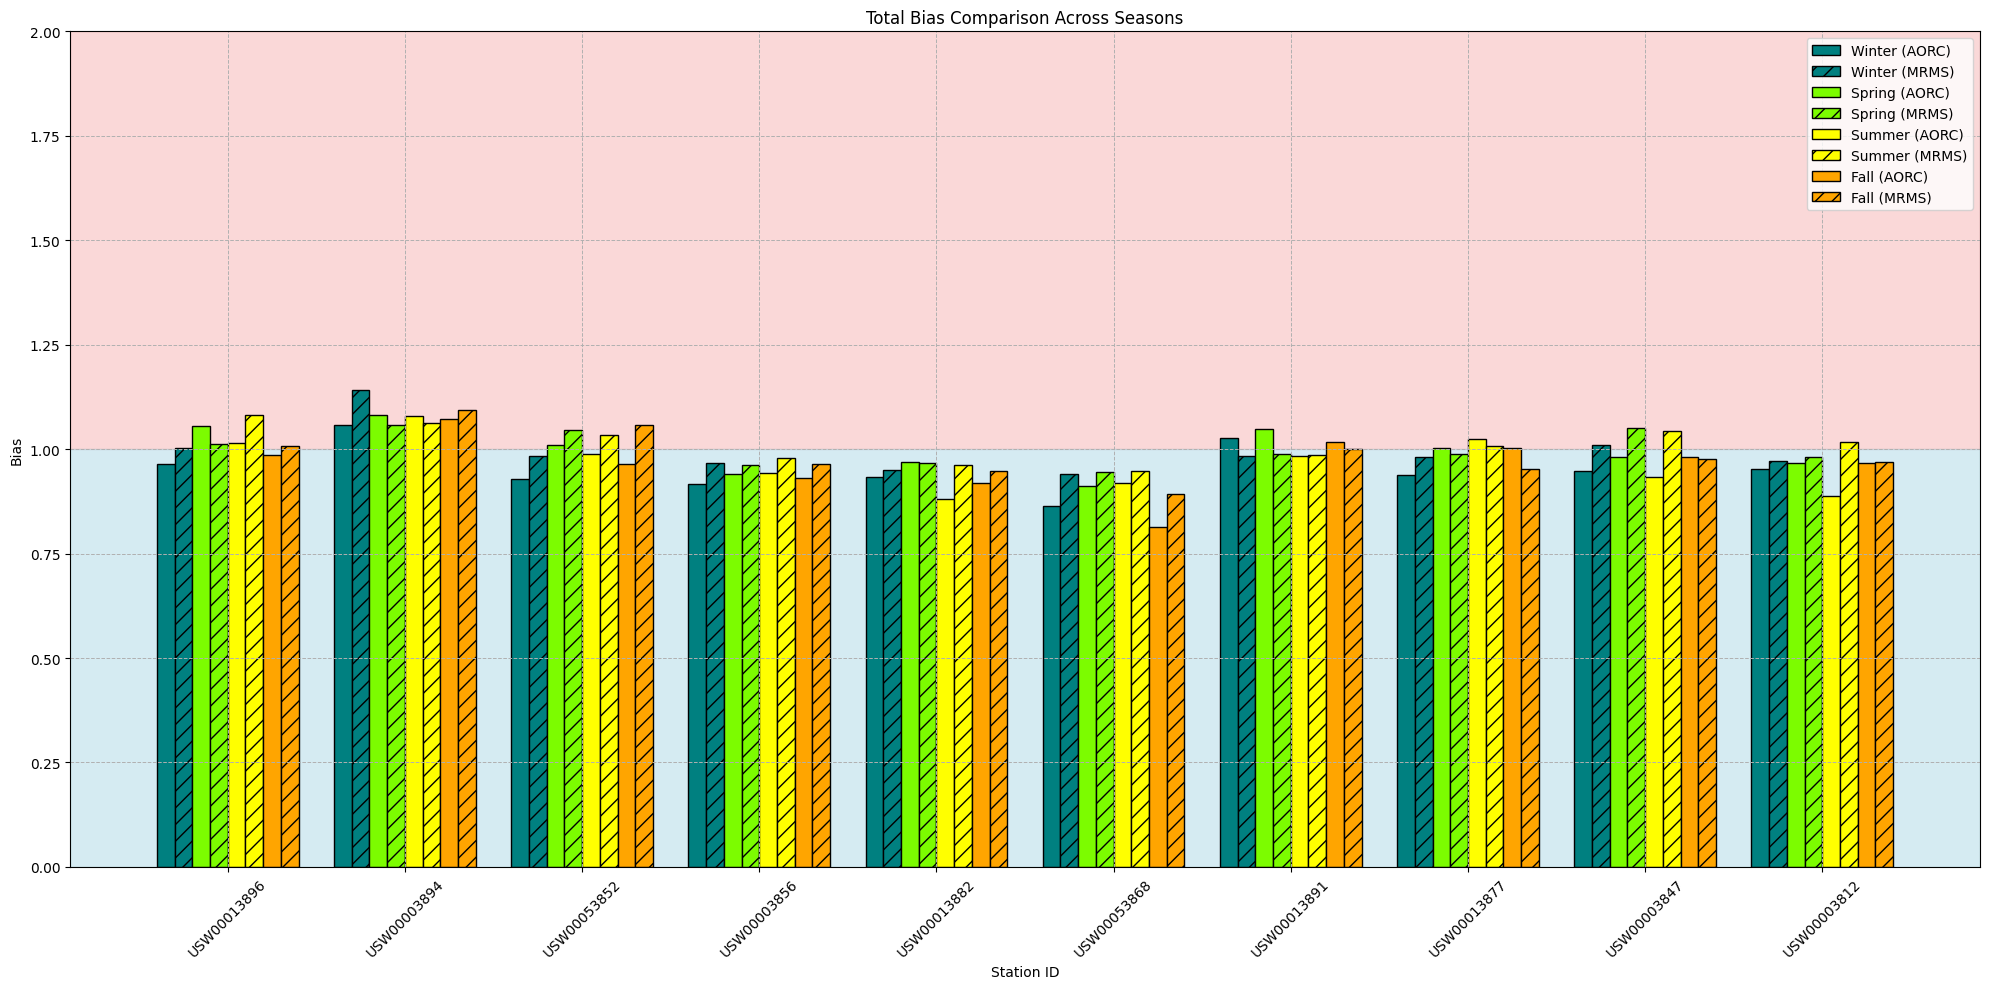

In [429]:
# Function to plot bias comparison across all seasons
def plot_bias_comparison_all_seasons(dict1, dict2, bias_column):
    seasons = list(dict1.keys())
    station_ids = dict1[seasons[0]]['Station ID']  # Assuming all dataframes have the same stations

    # Set up bar width and x locations
    width = 0.10
    x = np.arange(len(station_ids))

    # Colors assigned to each season
    season_colors = {
        'Summer': 'yellow',
        'Winter': 'teal',
        'Spring': 'lawngreen',
        'Fall': 'orange'
    }

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for i, season in enumerate(seasons):
        data1 = dict1[season][bias_column]
        data2 = dict2[season][bias_column]
        
        # Bars for dict1 with season color
        ax.bar(x + i * 2 * width, data1, width, label=f'{season} (AORC)', color=season_colors[season], edgecolor='black')
        # Bars for dict2 with season color and hatch pattern
        ax.bar(x + i * 2 * width + width, data2, width, label=f'{season} (MRMS)', color=season_colors[season], hatch='//', edgecolor='black')
    
    # Adding labels and title
    ax.set_xlabel('Station ID')
    ax.set_ylabel('Bias')
    ax.set_title(f'{bias_column} Comparison Across Seasons')
    ax.set_xticks(x + width * (len(seasons) - 0.5))
    ax.set_xticklabels(station_ids, rotation=45)

    ax.set_ylim(0,2)

    # Get the current axis limits
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()

    # Color the region above y=0 in light red, ensuring it covers the whole area up to the plot's edges
    ax.fill_between(x_limits, 1, y_limits[1], color='lightcoral', alpha=0.3, zorder=-1)

    # Color the region below y=0 in light blue, ensuring it covers the whole area up to the plot's edges
    ax.fill_between(x_limits, y_limits[0], 1, color='lightblue', alpha=0.5, zorder=-1)

    # Ensure the plot limits don't change after the fill
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # Adding grid, legend, and tight layout
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)
    ax.legend(loc='upper right')
    plt.tight_layout()
    
    plt.show()
# Now let's plot for the '70-90% Bias' across all seasons
plot_bias_comparison_all_seasons(aorc_dfs, mrms_dfs, 'Total Bias')


[0.665711902576646, 1.735973247707895, 1.0018424471813794, 0.6774860040925953, 0.3493639472220233]


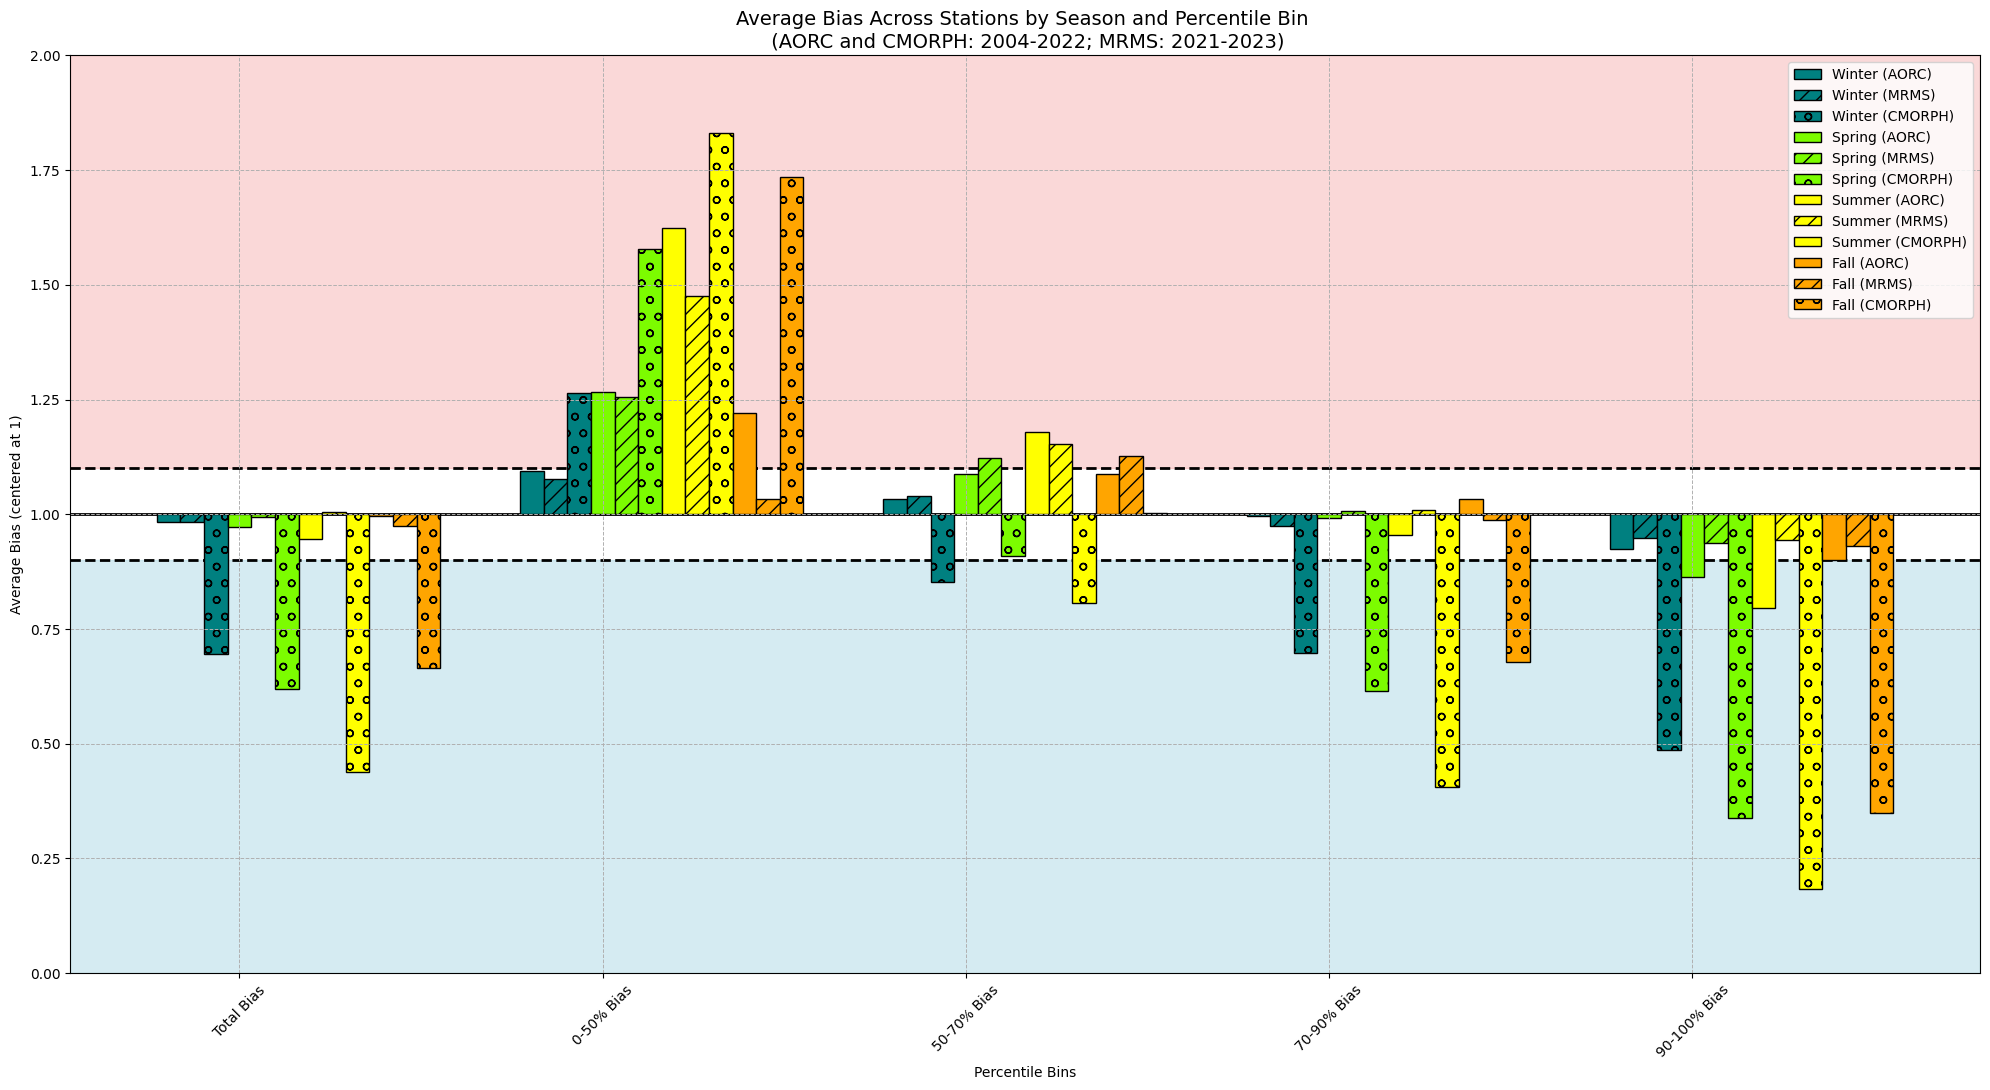

In [120]:
# Function to calculate and plot the average bias across all stations for each season and percentile bin
def plot_average_bias_by_season(dict1, dict2, dict3, bias_columns):
    seasons = dict1.keys()
    
    # Initialize storage for averages
    avg_bias_dict1 = {season: [] for season in seasons}
    avg_bias_dict2 = {season: [] for season in seasons}
    avg_bias_dict3 = {season: [] for season in seasons}
    
    # Calculate the averages
    for season in seasons:
        for bias_column in bias_columns:
            avg_bias_dict1[season].append(dict1[season][bias_column].mean())
            avg_bias_dict2[season].append(dict2[season][bias_column].mean())
            avg_bias_dict3[season].append(dict3[season][bias_column].mean())

    # Set up plot parameters
    width = 0.065  # Width of the bars
    x = np.arange(len(bias_columns))  # X locations for the groups

    # Colors assigned to each season
    season_colors = {
        'Summer': 'yellow',
        'Winter': 'teal',
        'Spring': 'lawngreen',
        'Fall': 'orange'
    }

    fig, ax = plt.subplots(figsize=(20, 11))
    
    # Plotting each season with bars centered around y=1
    for i, season in enumerate(seasons):
        ax.bar(x + i * width * 3, np.array(avg_bias_dict1[season]) - 1, width, 
               label=f'{season} (AORC)', color=season_colors[season], edgecolor='black', bottom=1)
        ax.bar(x + i * width * 3 + width, np.array(avg_bias_dict2[season]) - 1, width, 
               label=f'{season} (MRMS)', color=season_colors[season], hatch='//', edgecolor='black', bottom=1)
        ax.bar(x + i * width * 3 + 2*width, np.array(avg_bias_dict3[season]) - 1, width, 
               label=f'{season} (CMORPH)', color=season_colors[season], hatch='o', edgecolor='black', bottom=1)
        
    print(avg_bias_dict3['Fall'])
    
    # Labeling
    ax.set_xlabel('Percentile Bins')
    ax.set_ylabel('Average Bias (centered at 1)')
    ax.set_title(f'Average Bias Across Stations by Season and Percentile Bin \n (AORC and CMORPH: {years[0]}-{years[-1]}; MRMS: 2021-2023)', fontsize=14)
    ax.set_xticks(x + width * (len(seasons) - 1))
    ax.set_xticklabels(bias_columns, rotation=45)
    
    # Adjust the y-limits to center around 1
    ax.set_ylim(0, 2)

    # Get the current axis limits
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()

    # Color the region above y=1 in light red, ensuring it covers the whole area up to the plot's edges
    ax.fill_between(x_limits, 1.1, y_limits[1], color='lightcoral', alpha=0.3, zorder=-1)

    # Color the region below y=1 in light blue, ensuring it covers the whole area down to the plot's edges
    ax.fill_between(x_limits, y_limits[0], 0.9, color='lightblue', alpha=0.5, zorder=-1)

    ax.plot(x_limits, [1,1], color='black', linewidth=2, zorder=-1)
    ax.plot(x_limits, [1.1,1.1], color='black', linewidth=2, linestyle='dashed', zorder=-1)
    ax.plot(x_limits, [0.9,0.9], color='black', linewidth=2, linestyle='dashed',zorder=-1)

    # Ensure the plot limits don't change after the fill
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    # Adding grid, legend, and tight layout
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)
    ax.legend(loc='upper right')
    plt.tight_layout()
    
    plt.show()


# Bias columns to consider
bias_columns = ['Total Bias', '0-50% Bias', '50-70% Bias', '70-90% Bias', '90-100% Bias']

# Call the plotting function
plot_average_bias_by_season(aorc_dfs, mrms_dfs, cmorph_dfs, bias_columns)

In [53]:
import matplotlib
matplotlib.use('widget')
%matplotlib widget

C:\Users\domenicbrooks\AppData\Local\Temp\ipykernel_21196\2920244792.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cleaned_geom = merged_gdf.geometry.buffer(0.01)


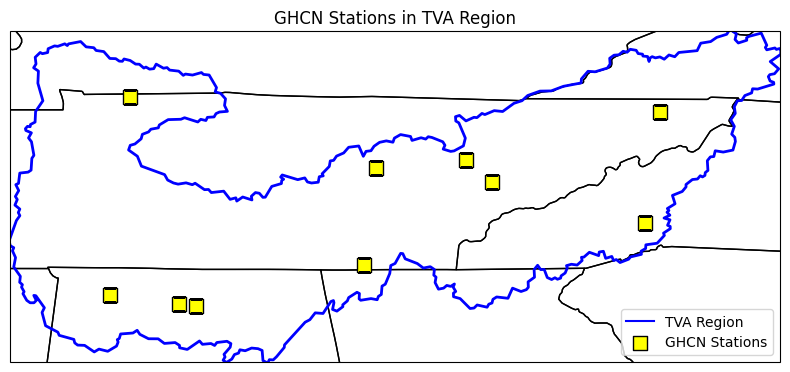

In [23]:
################################## Plotting the map and time series ##################################


############################# Creating the colormap ###################################
# draw filled contours.
clevs = [1, 10, 20, 40, 60, 80, 100, 120, 140]

# makes first color in colorbar white
colormap = matplotlib.colormaps['gist_ncar']
newcolors = colormap(np.linspace(0, 1, 9))
#white = np.array([0, 0, 0, 0]) #rgb for white
#newcolors[:0, :] = white
cmap = mcolors.ListedColormap(colormap(np.linspace(0.35, 0.95, 9))) # selects range on colormap I want to use for my colors

norm = mcolors.BoundaryNorm(clevs, cmap.N) #normalizes the bounds for the color mapping

# set the colors above and below the max and min
cmap.set_under('white')
cmap.set_over('lavenderblush')


# Set up the map
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])  # Adjust the extent based on your station locations

# Add features to the map
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=-1)


# Dissolve all polygons into one unified geometry
merged_gdf = gdf.dissolve()

# Apply a zero-distance buffer to clean up any topological issues
cleaned_geom = merged_gdf.geometry.buffer(0.01)

# Optionally, simplify the geometry to remove tiny artifacts (adjust tolerance as needed)
simplified_geom = cleaned_geom.simplify(tolerance=0.01, preserve_topology=True)

# Plot the cleaned and simplified polygon outline on the map
ax.add_geometries(simplified_geom, crs=ccrs.PlateCarree(), edgecolor='blue', facecolor='none', linewidth=2)


# Create a custom legend for the polygon outline
ax.plot(0,0, label='TVA Region', color='blue')

#plot aorc data
#im = ax.pcolormesh(aorc_data.longitude.values, aorc_data.latitude.values, aorc_data.sum(dim='time').values, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
# Add color bar
#cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, extend='max', label=' AORC Precipitation (mm)')

# turn this on to see pixel locations
#for station_id3, row in tva_stations.iterrows():
    #ax.scatter(aorc_datasets[station_id3].longitude.values, aorc_datasets[station_id3].latitude.values,s=100, transform=ccrs.PlateCarree(), color='orange', marker='s')
    #ax.scatter(cmorph_datasets[station_id3].lon.values, cmorph_datasets[station_id3].lat.values,s=100, transform=ccrs.PlateCarree(), color='r', marker='o')

#ax.scatter(1, 1,s=100, transform=ccrs.PlateCarree(), color='orange', marker='s', label='AORC Pixels')
#ax.scatter(1, 1,s=100, transform=ccrs.PlateCarree(), color='r', marker='o', label='CMORPH Pixels')

#starttime = pd.to_datetime(aorc_data.time.values[0])
#endtime = pd.to_datetime(aorc_data.time.values[-1])
#stat_id = 'USW00053868'

# Plot station locations
scatter = ax.scatter(tva_stations2['Longitude'], tva_stations2['Latitude'], color='yellow', s=90, marker='s', edgecolor='black', transform=ccrs.PlateCarree(), picker=True, label='GHCN Stations', zorder=0)

# use this line if you just want to plot a single station
#scatter = ax.scatter(tva_stations2.loc[tva_stations2['Station ID'] == stat_id]['Longitude'], tva_stations2.loc[tva_stations2['Station ID'] == stat_id]['Latitude'], color='black', s=90, marker='*', transform=ccrs.PlateCarree(), picker=True)

#ax.set_title('ACIS Stations in TVA Region \n and AORC Precip for {0} to {1}'.format(starttime.strftime("%Y-%m-%d %Hz"), endtime.strftime("%Y-%m-%d %Hz")))
ax.set_title('GHCN Stations in TVA Region')
ax.legend(loc='lower right')

# Function to plot time series for the selected station
def plot_timeseries(station_id):

    # stations
    station_ds = station_datasets[station_id]
    station_df_test = station_ds.to_dataframe().reset_index()

    # aorc data
    aorc_ds = aorc_datasets[station_id]
    aorc_df = aorc_ds.to_dataframe().reset_index()

    #cmorph data
    cmorph_ds = cmorph_datasets[station_id]
    cmorph_df = cmorph_ds.to_dataframe().reset_index()

    # mrms data (if possible)
    mrms_ds2 = mrms_datasets[station_id]
    mrms_df = mrms_ds2.to_dataframe().reset_index()

    fig2, ax = plt.subplots(figsize=(12, 6))
    ax.plot(station_df_test['time'], station_df_test['Hourly Precip'], marker='o', c='blue', label='Station Precip')
    ax.plot(aorc_df['time'], aorc_df['APCP_surface'], marker='o', c='orange', label='AORC Pixel Precip')
    ax.plot(cmorph_df['time'], cmorph_df['cmorph'], marker='o', c='green', label='CMORPH Pixel Precip')
    ax.plot(mrms_df['time'], mrms_df['unknown'], marker='o', c='red', label='MRMS Pixel Precip')
    ax.set_title(f'Precip Time Series for {station_id} and \n AORC, CMORPH Collocated Pixel')

    # Format the x-axis ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %Hz'))

    ax.set_xlabel('Time')
    ax.set_ylabel('Hourly Precip (mm)')
    ax.grid(axis='both')
    ax.legend(loc=0)
    plt.show()

# mplcursors to make the points interactive
cursor = mplcursors.cursor(scatter, hover=True)

@cursor.connect("add")
def on_add(sel):
    station_id = tva_stations2.iloc[sel.index]['Station ID']
    sel.annotation.set(text=station_id)
    sel.annotation.draggable(True)
    #plot_timeseries(station_id)

# Connect the pick event to the plot_timeseries function
def on_pick(event):
    ind = event.ind[0]
    station_id = tva_stations2.iloc[ind]['Station ID']
    plot_timeseries(station_id)

fig.canvas.mpl_connect("pick_event", on_pick)
#fig.canvas.mpl_connect("pick_event", lambda event: plot_timeseries(tva_stations2.iloc[event.ind[0]]['Station ID']))

plt.tight_layout()
plt.show()